In [1]:
import scanpy as sc

/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing 

In [ ]:
adata = sc.read_h5ad("./sdevelo_erythroid.h5ad")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the potential model
class PotentialNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(PotentialNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Output is scalar potential
        )

    def forward(self, x):
        return self.net(x)

In [4]:
model = PotentialNN(input_dim=2000)

data_x = torch.Tensor(adata.layers["spliced"].toarray())
data_y = torch.Tensor(adata.layers["sde_velocity"])

(Working on SDEvelo 0.2.12)
2025-01-13 17:50:12
computing velocity graph (using 6/6 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/haziq/mambaforge/envs/hgsoc/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing 

    finished (0:00:28) --> added 
    'sde_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'sde_velocity_length' (adata.obs)
--> added 'sde_velocity_confidence' (adata.obs)
--> added 'sde_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'sde_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_test.png


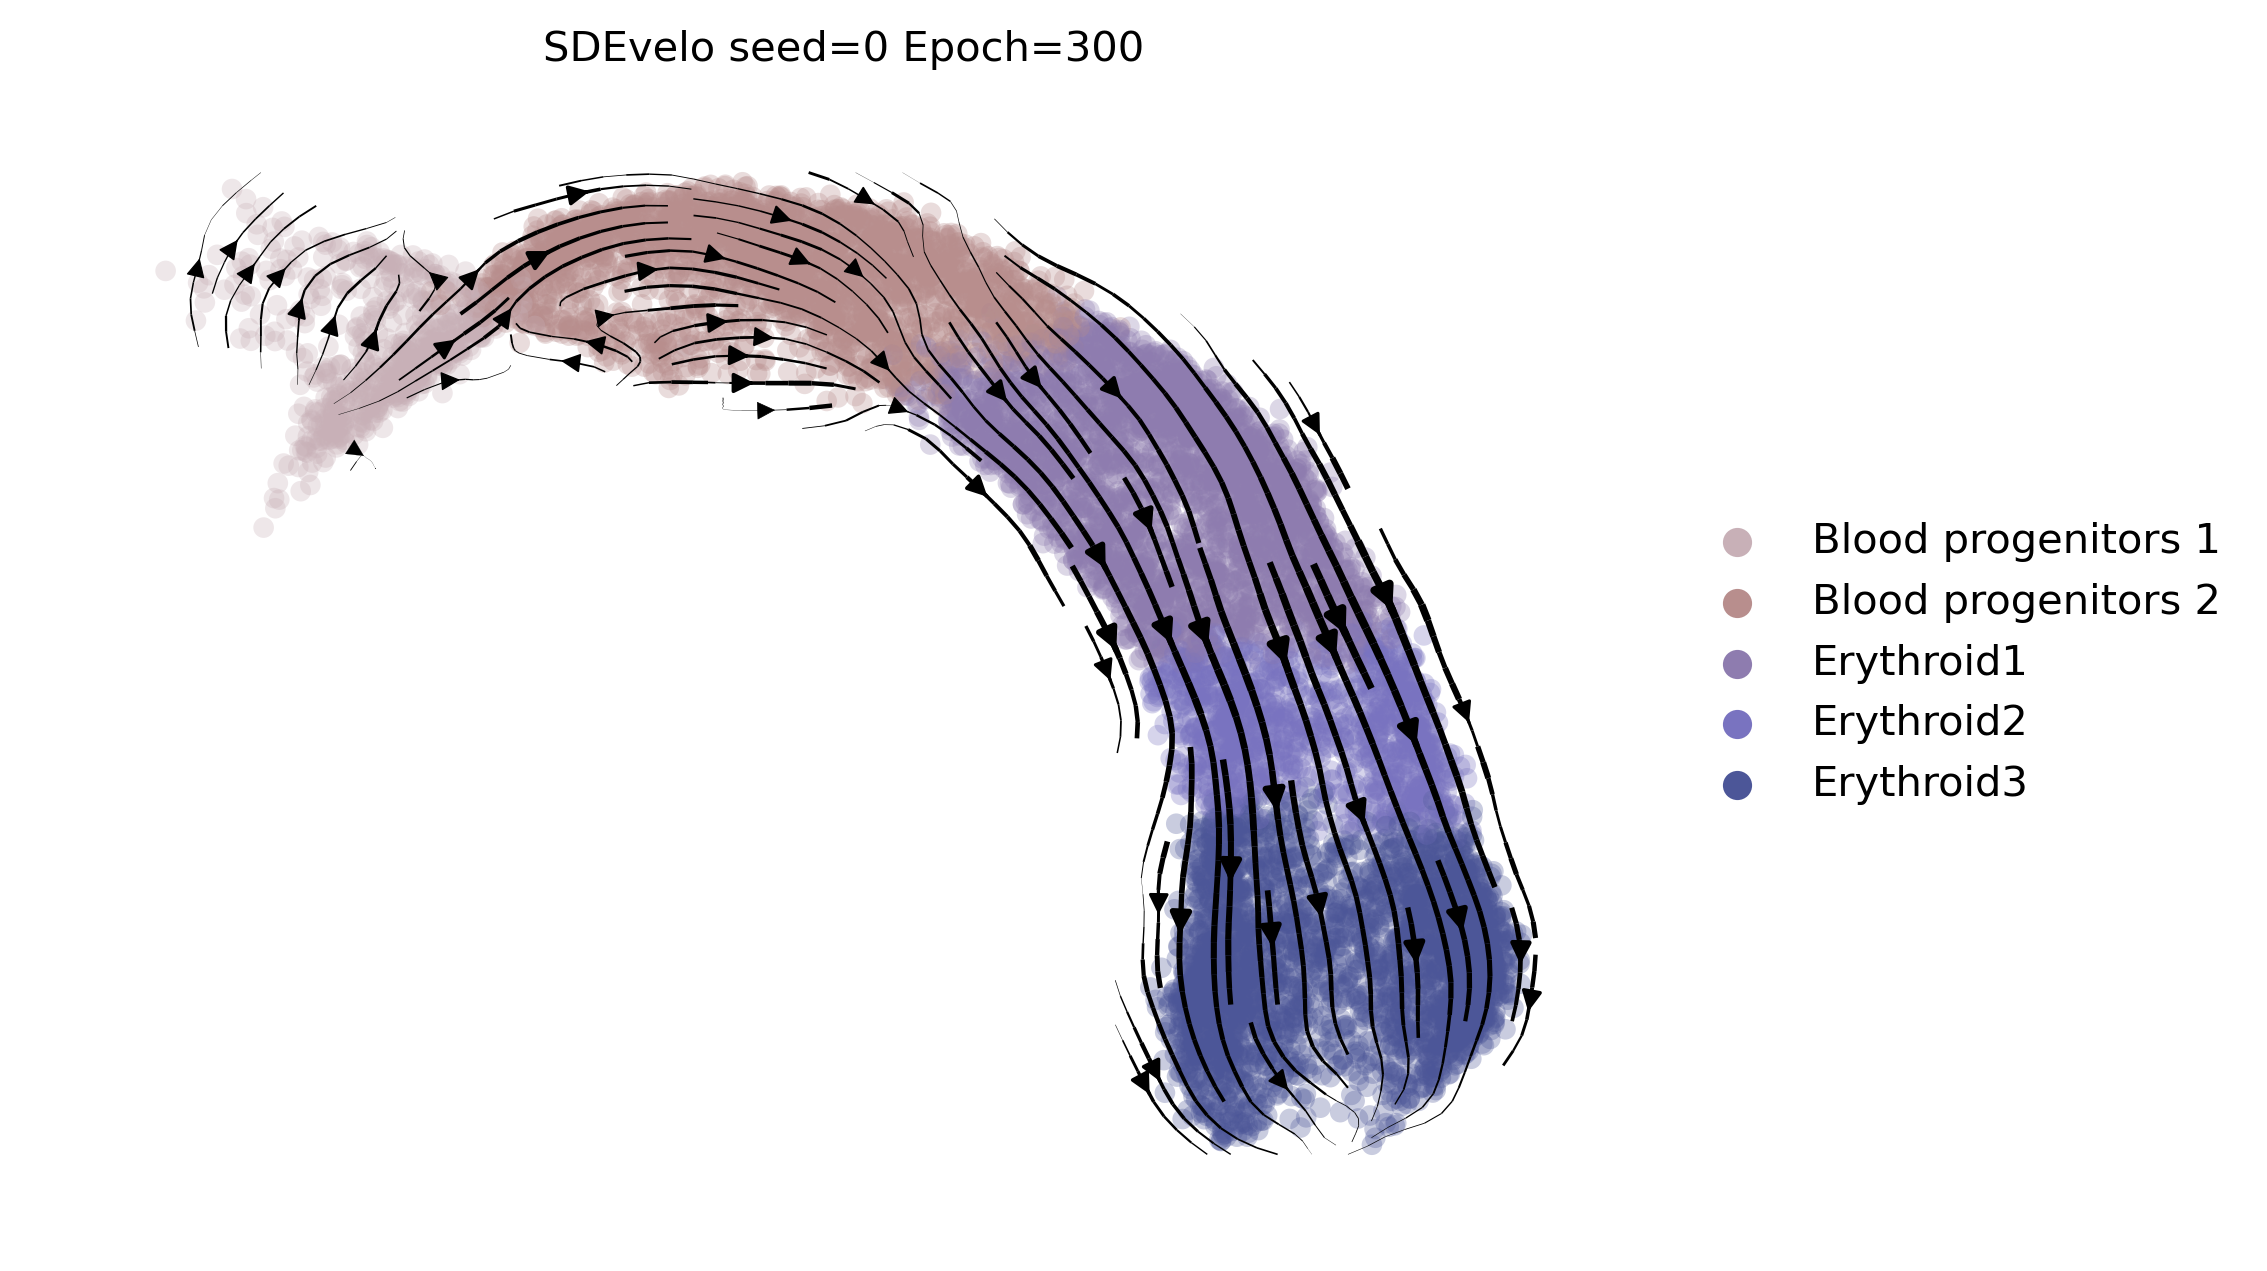

In [5]:
import sdevelo as sv
import scvelo as scv

args = sv.Config()

args.vis_type_col = 'celltype'
args.vis_key = 'X_umap'

color_list = ["#c8b0b7", "#b88e8d", "#8e7caf", "#7973c0", "#4c5698"]
adata.uns['celltype_colors'] = {cell_type: color_list[i] for i, cell_type in enumerate(adata.obs['celltype'].cat.categories.tolist())}

kwargs = dict(add_margin=.1, figsize=(7, 5))
sv.plot_streamline(adata, args, **kwargs, save='test.png',)

computing velocity graph (using 6/6 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:24) --> added 
    'sde_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'sde_velocity_length' (adata.obs)
--> added 'sde_velocity_confidence' (adata.obs)
computing velocity embedding
    finished (0:00:01) --> added
    'sde_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_test.png


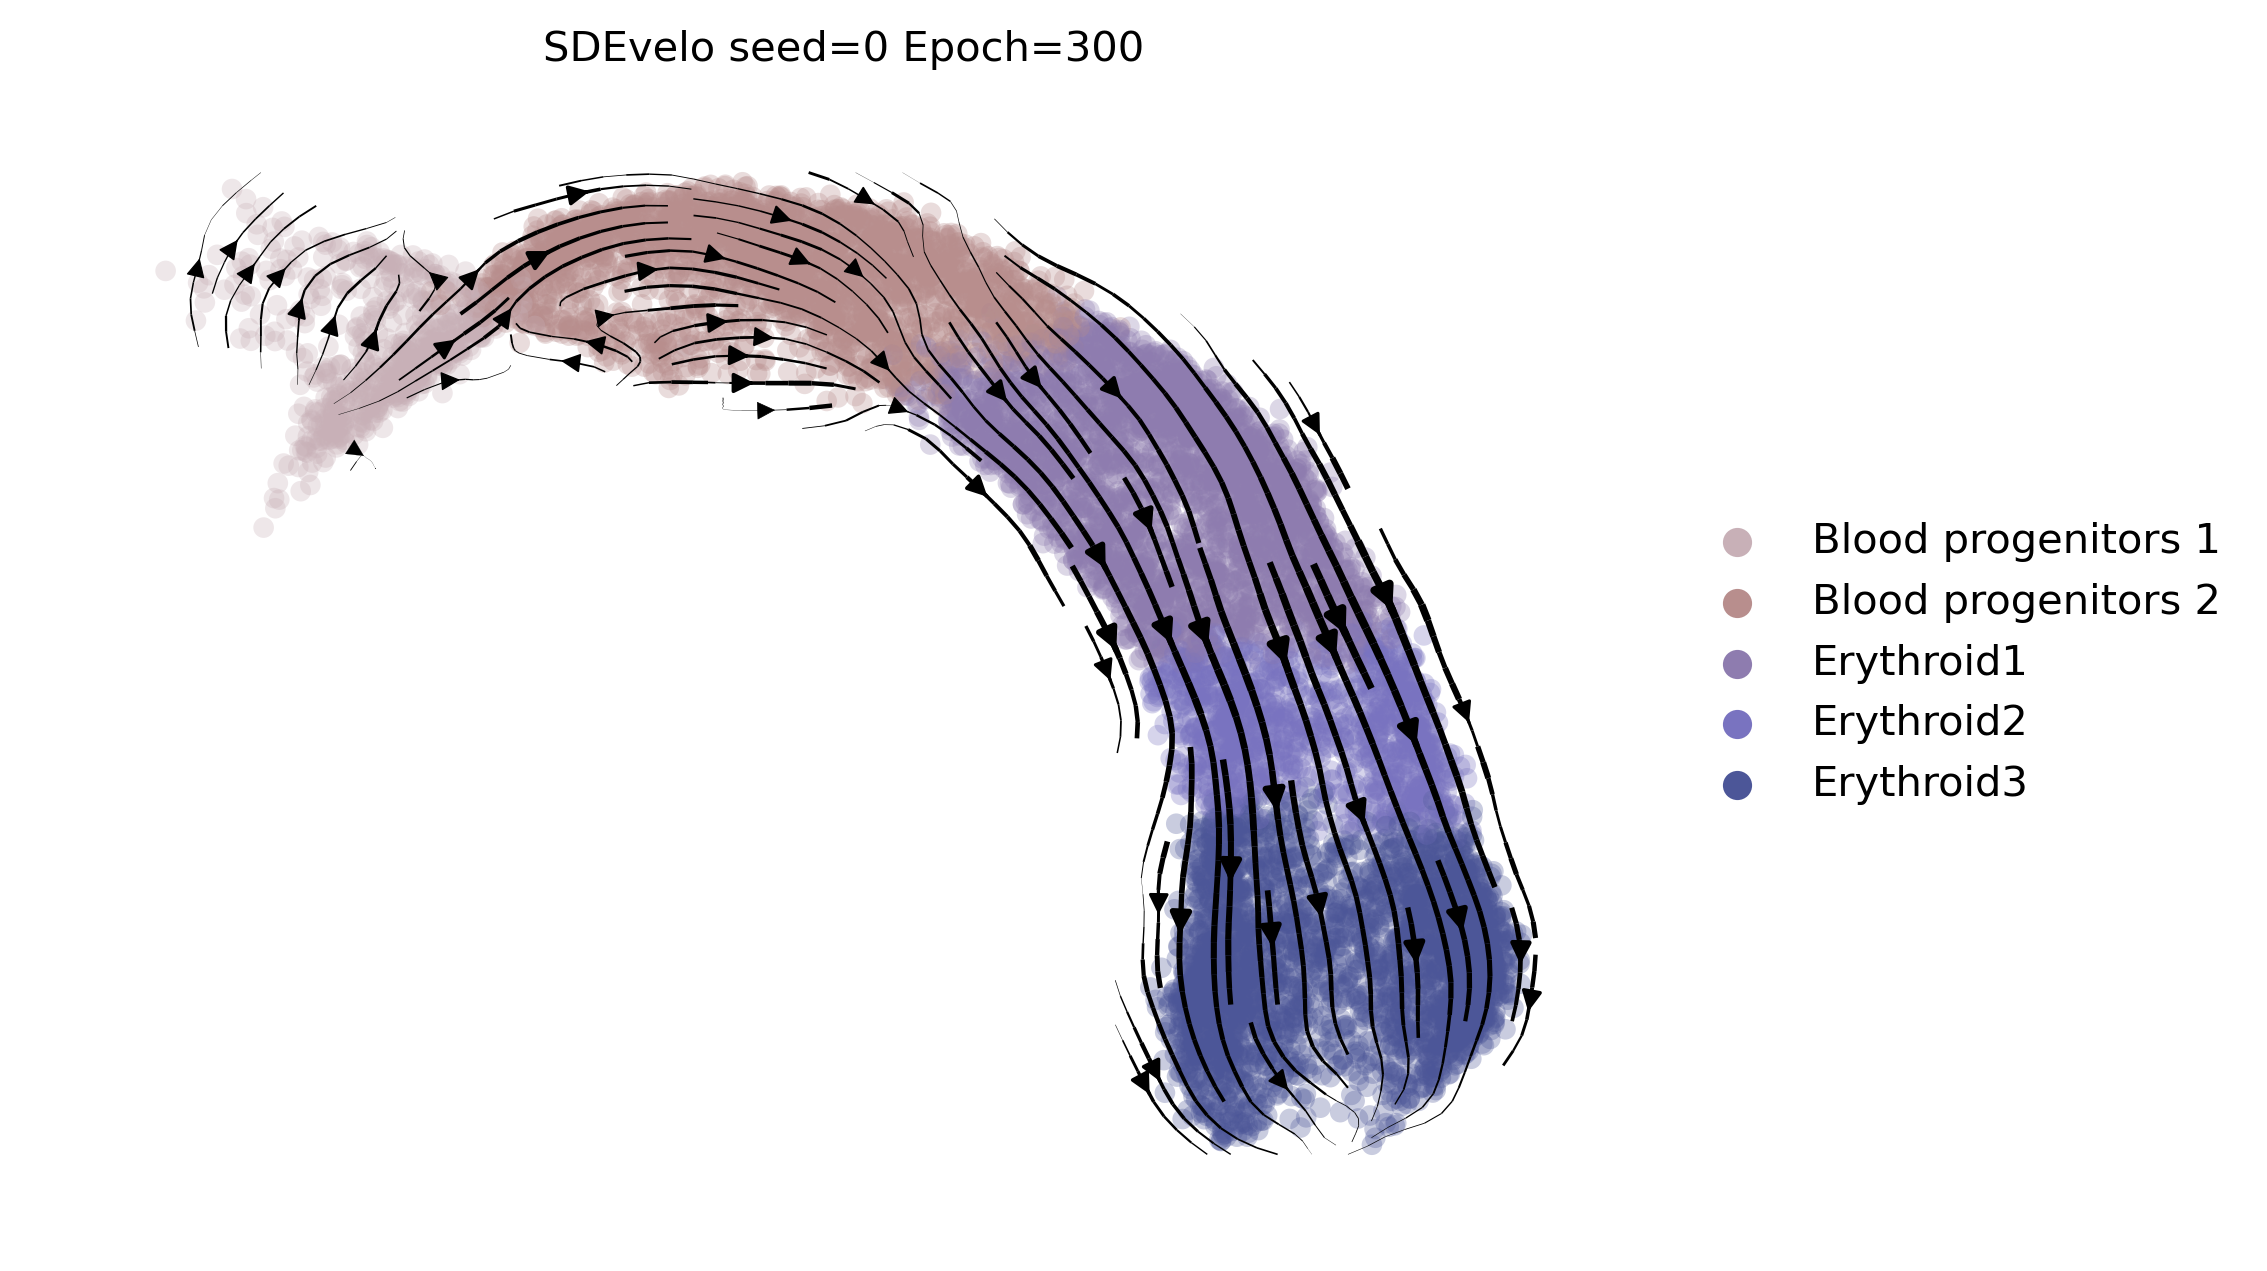

In [6]:
sv.plot_streamline(adata, args, **kwargs, save='test.png',)

In [7]:
import torch
from torch.autograd import grad

def compute_gradient(potential, x):
    grad_outputs = torch.ones_like(potential)
    gradients = grad(outputs=potential, inputs=x, grad_outputs=grad_outputs, create_graph=True)[0]
    return gradients

In [8]:
from tqdm import tqdm
import torch.optim as optim

# Set training parameters
epochs = 1000
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

# Ensure gradients can be calculated for input data
data_x.requires_grad_()
data_y.requires_grad_()

# Training loop with tqdm progress bar
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    optimizer.zero_grad()

    # Compute potential and gradient
    potentials = model(data_x)
    gradients = compute_gradient(potentials, data_x)

    # Compute loss
    loss = torch.mean((data_y + gradients) ** 2)
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    tqdm.write(f"Epoch {epoch}, Loss: {loss.item()}")


Training Progress:   0%|          | 2/1000 [00:00<02:31,  6.58it/s]

Epoch 0, Loss: 0.11489700525999069
Epoch 1, Loss: 0.11488763242959976


Training Progress:   0%|          | 4/1000 [00:00<02:25,  6.82it/s]

Epoch 2, Loss: 0.11487819999456406
Epoch 3, Loss: 0.11486892402172089


Training Progress:   1%|          | 6/1000 [00:00<02:23,  6.91it/s]

Epoch 4, Loss: 0.11486001312732697
Epoch 5, Loss: 0.11485147476196289


Training Progress:   1%|          | 7/1000 [00:01<02:22,  6.96it/s]

Epoch 6, Loss: 0.11484310775995255


Training Progress:   1%|          | 9/1000 [00:01<02:37,  6.30it/s]

Epoch 7, Loss: 0.11483466625213623
Epoch 8, Loss: 0.1148260086774826


Training Progress:   1%|          | 11/1000 [00:01<02:28,  6.65it/s]

Epoch 9, Loss: 0.11481698602437973
Epoch 10, Loss: 0.1148076057434082


Training Progress:   1%|▏         | 13/1000 [00:01<02:23,  6.86it/s]

Epoch 11, Loss: 0.11479778587818146
Epoch 12, Loss: 0.11478758603334427


Training Progress:   2%|▏         | 15/1000 [00:02<02:22,  6.92it/s]

Epoch 13, Loss: 0.11477690935134888
Epoch 14, Loss: 0.11476586759090424


Training Progress:   2%|▏         | 17/1000 [00:02<02:20,  7.02it/s]

Epoch 15, Loss: 0.11475453525781631
Epoch 16, Loss: 0.11474286764860153


Training Progress:   2%|▏         | 19/1000 [00:02<02:18,  7.06it/s]

Epoch 17, Loss: 0.1147308349609375
Epoch 18, Loss: 0.1147184818983078


Training Progress:   2%|▏         | 21/1000 [00:03<02:19,  7.01it/s]

Epoch 19, Loss: 0.11470574140548706
Epoch 20, Loss: 0.11469259113073349


Training Progress:   2%|▏         | 23/1000 [00:03<02:19,  6.99it/s]

Epoch 21, Loss: 0.11467903852462769
Epoch 22, Loss: 0.11466515809297562


Training Progress:   2%|▎         | 25/1000 [00:03<02:20,  6.95it/s]

Epoch 23, Loss: 0.1146509051322937
Epoch 24, Loss: 0.11463623493909836


Training Progress:   3%|▎         | 27/1000 [00:03<02:19,  6.98it/s]

Epoch 25, Loss: 0.1146211177110672
Epoch 26, Loss: 0.11460552364587784


Training Progress:   3%|▎         | 29/1000 [00:04<02:19,  6.95it/s]

Epoch 27, Loss: 0.11458960920572281
Epoch 28, Loss: 0.11457303911447525


Training Progress:   3%|▎         | 30/1000 [00:04<02:20,  6.92it/s]

Epoch 29, Loss: 0.11455594748258591


Training Progress:   3%|▎         | 32/1000 [00:04<02:33,  6.32it/s]

Epoch 30, Loss: 0.11453840881586075
Epoch 31, Loss: 0.11452022194862366


Training Progress:   3%|▎         | 34/1000 [00:05<02:24,  6.69it/s]

Epoch 32, Loss: 0.11450155079364777
Epoch 33, Loss: 0.11448226869106293


Training Progress:   4%|▎         | 36/1000 [00:05<02:21,  6.83it/s]

Epoch 34, Loss: 0.1144622266292572
Epoch 35, Loss: 0.11444172263145447


Training Progress:   4%|▍         | 38/1000 [00:05<02:19,  6.90it/s]

Epoch 36, Loss: 0.11442060768604279
Epoch 37, Loss: 0.11439888179302216


Training Progress:   4%|▍         | 40/1000 [00:05<02:17,  6.98it/s]

Epoch 38, Loss: 0.11437632143497467
Epoch 39, Loss: 0.11435313522815704


Training Progress:   4%|▍         | 42/1000 [00:06<02:19,  6.87it/s]

Epoch 40, Loss: 0.1143292635679245
Epoch 41, Loss: 0.11430473625659943


Training Progress:   4%|▍         | 44/1000 [00:06<02:18,  6.89it/s]

Epoch 42, Loss: 0.11427944153547287
Epoch 43, Loss: 0.11425331234931946


Training Progress:   5%|▍         | 46/1000 [00:06<02:17,  6.94it/s]

Epoch 44, Loss: 0.1142263263463974
Epoch 45, Loss: 0.11419863998889923


Training Progress:   5%|▍         | 48/1000 [00:07<02:15,  7.03it/s]

Epoch 46, Loss: 0.11417018622159958
Epoch 47, Loss: 0.11414072662591934


Training Progress:   5%|▌         | 50/1000 [00:07<02:14,  7.05it/s]

Epoch 48, Loss: 0.11411041766405106
Epoch 49, Loss: 0.11407914012670517


Training Progress:   5%|▌         | 52/1000 [00:07<02:15,  6.99it/s]

Epoch 50, Loss: 0.1140470951795578
Epoch 51, Loss: 0.11401386559009552


Training Progress:   5%|▌         | 54/1000 [00:07<02:25,  6.52it/s]

Epoch 52, Loss: 0.11397992819547653
Epoch 53, Loss: 0.11394509673118591


Training Progress:   6%|▌         | 56/1000 [00:08<02:18,  6.80it/s]

Epoch 54, Loss: 0.11390934884548187
Epoch 55, Loss: 0.11387263238430023


Training Progress:   6%|▌         | 58/1000 [00:08<02:14,  7.02it/s]

Epoch 56, Loss: 0.11383465677499771
Epoch 57, Loss: 0.11379554122686386


Training Progress:   6%|▌         | 60/1000 [00:08<02:12,  7.09it/s]

Epoch 58, Loss: 0.1137554869055748
Epoch 59, Loss: 0.11371415108442307


Training Progress:   6%|▌         | 62/1000 [00:09<02:11,  7.14it/s]

Epoch 60, Loss: 0.11367167532444
Epoch 61, Loss: 0.1136280968785286


Training Progress:   6%|▋         | 64/1000 [00:09<02:12,  7.08it/s]

Epoch 62, Loss: 0.11358339339494705
Epoch 63, Loss: 0.11353739351034164


Training Progress:   7%|▋         | 66/1000 [00:09<02:14,  6.92it/s]

Epoch 64, Loss: 0.11349029839038849
Epoch 65, Loss: 0.11344195157289505


Training Progress:   7%|▋         | 68/1000 [00:09<02:13,  7.00it/s]

Epoch 66, Loss: 0.11339239776134491
Epoch 67, Loss: 0.11334160715341568


Training Progress:   7%|▋         | 70/1000 [00:10<02:11,  7.06it/s]

Epoch 68, Loss: 0.11328941583633423
Epoch 69, Loss: 0.11323583871126175


Training Progress:   7%|▋         | 72/1000 [00:10<02:11,  7.08it/s]

Epoch 70, Loss: 0.11318095028400421
Epoch 71, Loss: 0.11312423646450043


Training Progress:   7%|▋         | 74/1000 [00:10<02:09,  7.16it/s]

Epoch 72, Loss: 0.11306612193584442
Epoch 73, Loss: 0.11300656199455261


Training Progress:   8%|▊         | 76/1000 [00:11<02:19,  6.60it/s]

Epoch 74, Loss: 0.112945556640625
Epoch 75, Loss: 0.11288322508335114


Training Progress:   8%|▊         | 78/1000 [00:11<02:13,  6.90it/s]

Epoch 76, Loss: 0.1128193810582161
Epoch 77, Loss: 0.11275383085012436


Training Progress:   8%|▊         | 80/1000 [00:11<02:12,  6.96it/s]

Epoch 78, Loss: 0.11268716305494308
Epoch 79, Loss: 0.1126193180680275


Training Progress:   8%|▊         | 82/1000 [00:11<02:09,  7.12it/s]

Epoch 80, Loss: 0.11255038529634476
Epoch 81, Loss: 0.11247976124286652


Training Progress:   8%|▊         | 84/1000 [00:12<02:08,  7.14it/s]

Epoch 82, Loss: 0.11240734905004501
Epoch 83, Loss: 0.1123335212469101


Training Progress:   9%|▊         | 86/1000 [00:12<02:18,  6.60it/s]

Epoch 84, Loss: 0.11225786805152893
Epoch 85, Loss: 0.11218062788248062


Training Progress:   9%|▉         | 88/1000 [00:12<02:13,  6.84it/s]

Epoch 86, Loss: 0.11210183054208755
Epoch 87, Loss: 0.11202125251293182


Training Progress:   9%|▉         | 90/1000 [00:13<02:09,  7.01it/s]

Epoch 88, Loss: 0.1119389459490776
Epoch 89, Loss: 0.11185552924871445


Training Progress:   9%|▉         | 92/1000 [00:13<02:08,  7.09it/s]

Epoch 90, Loss: 0.1117696613073349
Epoch 91, Loss: 0.11168200522661209


Training Progress:   9%|▉         | 94/1000 [00:13<02:07,  7.10it/s]

Epoch 92, Loss: 0.11159252375364304
Epoch 93, Loss: 0.11150097101926804


Training Progress:  10%|▉         | 96/1000 [00:13<02:16,  6.63it/s]

Epoch 94, Loss: 0.1114073097705841
Epoch 95, Loss: 0.11131154000759125


Training Progress:  10%|▉         | 98/1000 [00:14<02:12,  6.83it/s]

Epoch 96, Loss: 0.11121440678834915
Epoch 97, Loss: 0.1111149787902832


Training Progress:  10%|█         | 100/1000 [00:14<02:08,  7.02it/s]

Epoch 98, Loss: 0.11101336032152176
Epoch 99, Loss: 0.11091027408838272


Training Progress:  10%|█         | 102/1000 [00:14<02:06,  7.09it/s]

Epoch 100, Loss: 0.11080459505319595
Epoch 101, Loss: 0.110696941614151


Training Progress:  10%|█         | 104/1000 [00:15<02:05,  7.12it/s]

Epoch 102, Loss: 0.1105872169137001
Epoch 103, Loss: 0.11047500371932983


Training Progress:  11%|█         | 106/1000 [00:15<02:06,  7.05it/s]

Epoch 104, Loss: 0.11036123335361481
Epoch 105, Loss: 0.11024509370326996


Training Progress:  11%|█         | 108/1000 [00:15<02:07,  7.01it/s]

Epoch 106, Loss: 0.11012707650661469
Epoch 107, Loss: 0.11000654846429825


Training Progress:  11%|█         | 110/1000 [00:15<02:08,  6.93it/s]

Epoch 108, Loss: 0.10988391190767288
Epoch 109, Loss: 0.10975891351699829


Training Progress:  11%|█         | 112/1000 [00:16<02:05,  7.07it/s]

Epoch 110, Loss: 0.1096314936876297
Epoch 111, Loss: 0.10950091481208801


Training Progress:  11%|█▏        | 114/1000 [00:16<02:04,  7.11it/s]

Epoch 112, Loss: 0.10936787724494934
Epoch 113, Loss: 0.1092323586344719


Training Progress:  12%|█▏        | 115/1000 [00:16<02:03,  7.15it/s]

Epoch 114, Loss: 0.10909470170736313
Epoch 115, Loss: 0.10895388573408127


Training Progress:  12%|█▏        | 118/1000 [00:17<02:11,  6.72it/s]

Epoch 116, Loss: 0.10881079733371735
Epoch 117, Loss: 0.10866472125053406


Training Progress:  12%|█▏        | 120/1000 [00:17<02:06,  6.93it/s]

Epoch 118, Loss: 0.108515664935112
Epoch 119, Loss: 0.10836359858512878


Training Progress:  12%|█▏        | 122/1000 [00:17<02:05,  6.99it/s]

Epoch 120, Loss: 0.10820913314819336
Epoch 121, Loss: 0.10805155336856842


Training Progress:  12%|█▏        | 124/1000 [00:17<02:04,  7.04it/s]

Epoch 122, Loss: 0.10789142549037933
Epoch 123, Loss: 0.107728973031044


Training Progress:  13%|█▎        | 126/1000 [00:18<02:03,  7.07it/s]

Epoch 124, Loss: 0.1075633242726326
Epoch 125, Loss: 0.10739561915397644


Training Progress:  13%|█▎        | 128/1000 [00:18<02:03,  7.09it/s]

Epoch 126, Loss: 0.10722456872463226
Epoch 127, Loss: 0.10705095529556274


Training Progress:  13%|█▎        | 130/1000 [00:18<02:02,  7.08it/s]

Epoch 128, Loss: 0.10687432438135147
Epoch 129, Loss: 0.10669505596160889


Training Progress:  13%|█▎        | 132/1000 [00:19<02:02,  7.09it/s]

Epoch 130, Loss: 0.10651297122240067
Epoch 131, Loss: 0.10632748156785965


Training Progress:  13%|█▎        | 134/1000 [00:19<02:02,  7.04it/s]

Epoch 132, Loss: 0.10614032298326492
Epoch 133, Loss: 0.1059490442276001


Training Progress:  14%|█▎        | 136/1000 [00:19<02:03,  6.98it/s]

Epoch 134, Loss: 0.10575412958860397
Epoch 135, Loss: 0.10555756092071533


Training Progress:  14%|█▍        | 138/1000 [00:20<02:14,  6.41it/s]

Epoch 136, Loss: 0.10535728186368942
Epoch 137, Loss: 0.10515455156564713


Training Progress:  14%|█▍        | 140/1000 [00:20<02:08,  6.71it/s]

Epoch 138, Loss: 0.10494902729988098
Epoch 139, Loss: 0.10474056005477905


Training Progress:  14%|█▍        | 142/1000 [00:20<02:04,  6.87it/s]

Epoch 140, Loss: 0.10452866554260254
Epoch 141, Loss: 0.10431421548128128


Training Progress:  14%|█▍        | 144/1000 [00:20<02:02,  6.98it/s]

Epoch 142, Loss: 0.10409650951623917
Epoch 143, Loss: 0.10387686640024185


Training Progress:  15%|█▍        | 146/1000 [00:21<02:00,  7.10it/s]

Epoch 144, Loss: 0.10365290194749832
Epoch 145, Loss: 0.10342561453580856


Training Progress:  15%|█▍        | 148/1000 [00:21<01:59,  7.13it/s]

Epoch 146, Loss: 0.10319500416517258
Epoch 147, Loss: 0.10296102613210678


Training Progress:  15%|█▌        | 150/1000 [00:21<01:58,  7.18it/s]

Epoch 148, Loss: 0.10272462666034698
Epoch 149, Loss: 0.10248460620641708


Training Progress:  15%|█▌        | 152/1000 [00:22<01:58,  7.15it/s]

Epoch 150, Loss: 0.10224045068025589
Epoch 151, Loss: 0.1019943356513977


Training Progress:  15%|█▌        | 154/1000 [00:22<01:58,  7.14it/s]

Epoch 152, Loss: 0.1017446219921112
Epoch 153, Loss: 0.10149181634187698


Training Progress:  16%|█▌        | 156/1000 [00:22<01:58,  7.13it/s]

Epoch 154, Loss: 0.10123609006404877
Epoch 155, Loss: 0.10097695887088776


Training Progress:  16%|█▌        | 158/1000 [00:22<02:09,  6.48it/s]

Epoch 156, Loss: 0.10071440786123276
Epoch 157, Loss: 0.10044895112514496


Training Progress:  16%|█▌        | 160/1000 [00:23<02:04,  6.76it/s]

Epoch 158, Loss: 0.10018076002597809
Epoch 159, Loss: 0.09990926086902618


Training Progress:  16%|█▌        | 162/1000 [00:23<02:00,  6.94it/s]

Epoch 160, Loss: 0.09963426738977432
Epoch 161, Loss: 0.0993557870388031


Training Progress:  16%|█▋        | 164/1000 [00:23<01:59,  6.97it/s]

Epoch 162, Loss: 0.0990753322839737
Epoch 163, Loss: 0.09878993779420853


Training Progress:  17%|█▋        | 166/1000 [00:24<01:58,  7.04it/s]

Epoch 164, Loss: 0.09850174188613892
Epoch 165, Loss: 0.0982106626033783


Training Progress:  17%|█▋        | 168/1000 [00:24<01:58,  7.04it/s]

Epoch 166, Loss: 0.09791627526283264
Epoch 167, Loss: 0.09761802107095718


Training Progress:  17%|█▋        | 170/1000 [00:24<01:56,  7.11it/s]

Epoch 168, Loss: 0.09731675684452057
Epoch 169, Loss: 0.09701264649629593


Training Progress:  17%|█▋        | 172/1000 [00:24<01:56,  7.09it/s]

Epoch 170, Loss: 0.0967053771018982
Epoch 171, Loss: 0.09639406949281693


Training Progress:  17%|█▋        | 174/1000 [00:25<01:55,  7.14it/s]

Epoch 172, Loss: 0.09607937186956406
Epoch 173, Loss: 0.09576235711574554


Training Progress:  18%|█▊        | 176/1000 [00:25<01:55,  7.12it/s]

Epoch 174, Loss: 0.09544085711240768
Epoch 175, Loss: 0.09511680901050568


Training Progress:  18%|█▊        | 177/1000 [00:25<01:55,  7.14it/s]

Epoch 176, Loss: 0.09479135274887085


Training Progress:  18%|█▊        | 179/1000 [00:25<02:06,  6.51it/s]

Epoch 177, Loss: 0.09446179121732712
Epoch 178, Loss: 0.09412933886051178


Training Progress:  18%|█▊        | 181/1000 [00:26<02:00,  6.79it/s]

Epoch 179, Loss: 0.09379549324512482
Epoch 180, Loss: 0.09345921874046326


Training Progress:  18%|█▊        | 183/1000 [00:26<01:56,  7.01it/s]

Epoch 181, Loss: 0.0931197851896286
Epoch 182, Loss: 0.09277746826410294


Training Progress:  18%|█▊        | 185/1000 [00:26<01:55,  7.04it/s]

Epoch 183, Loss: 0.09243186563253403
Epoch 184, Loss: 0.09208395332098007


Training Progress:  19%|█▊        | 187/1000 [00:27<01:54,  7.13it/s]

Epoch 185, Loss: 0.09173306822776794
Epoch 186, Loss: 0.09138064831495285


Training Progress:  19%|█▉        | 189/1000 [00:27<01:54,  7.10it/s]

Epoch 187, Loss: 0.09102371335029602
Epoch 188, Loss: 0.0906650647521019


Training Progress:  19%|█▉        | 191/1000 [00:27<01:52,  7.19it/s]

Epoch 189, Loss: 0.09030325710773468
Epoch 190, Loss: 0.08993857353925705


Training Progress:  19%|█▉        | 193/1000 [00:27<01:53,  7.14it/s]

Epoch 191, Loss: 0.08957264572381973
Epoch 192, Loss: 0.08920454233884811


Training Progress:  20%|█▉        | 195/1000 [00:28<01:53,  7.12it/s]

Epoch 193, Loss: 0.08883382380008698
Epoch 194, Loss: 0.0884615033864975


Training Progress:  20%|█▉        | 197/1000 [00:28<01:52,  7.16it/s]

Epoch 195, Loss: 0.08808634430170059
Epoch 196, Loss: 0.08770830929279327


Training Progress:  20%|█▉        | 198/1000 [00:28<01:53,  7.04it/s]

Epoch 197, Loss: 0.08732883632183075


Training Progress:  20%|██        | 200/1000 [00:28<02:06,  6.34it/s]

Epoch 198, Loss: 0.08694633096456528
Epoch 199, Loss: 0.08656229078769684


Training Progress:  20%|██        | 202/1000 [00:29<01:59,  6.66it/s]

Epoch 200, Loss: 0.08617545664310455
Epoch 201, Loss: 0.08578699082136154


Training Progress:  20%|██        | 204/1000 [00:29<01:55,  6.87it/s]

Epoch 202, Loss: 0.08539605140686035
Epoch 203, Loss: 0.08500348031520844


Training Progress:  21%|██        | 206/1000 [00:29<01:53,  6.98it/s]

Epoch 204, Loss: 0.0846078097820282
Epoch 205, Loss: 0.0842101201415062


Training Progress:  21%|██        | 208/1000 [00:30<01:52,  7.03it/s]

Epoch 206, Loss: 0.08381166309118271
Epoch 207, Loss: 0.08341199904680252


Training Progress:  21%|██        | 210/1000 [00:30<01:53,  6.95it/s]

Epoch 208, Loss: 0.08301068097352982
Epoch 209, Loss: 0.08260665088891983


Training Progress:  21%|██        | 212/1000 [00:30<01:55,  6.84it/s]

Epoch 210, Loss: 0.08220210671424866
Epoch 211, Loss: 0.08179476857185364


Training Progress:  21%|██▏       | 214/1000 [00:30<01:55,  6.81it/s]

Epoch 212, Loss: 0.0813872441649437
Epoch 213, Loss: 0.08097812533378601


Training Progress:  22%|██▏       | 216/1000 [00:31<01:55,  6.76it/s]

Epoch 214, Loss: 0.08056744188070297
Epoch 215, Loss: 0.08015415072441101


Training Progress:  22%|██▏       | 217/1000 [00:31<01:55,  6.76it/s]

Epoch 216, Loss: 0.07974021881818771


Training Progress:  22%|██▏       | 219/1000 [00:31<02:06,  6.17it/s]

Epoch 217, Loss: 0.07932423055171967
Epoch 218, Loss: 0.07890750467777252


Training Progress:  22%|██▏       | 221/1000 [00:32<02:01,  6.42it/s]

Epoch 219, Loss: 0.0784890204668045
Epoch 220, Loss: 0.0780702605843544


Training Progress:  22%|██▏       | 223/1000 [00:32<01:57,  6.60it/s]

Epoch 221, Loss: 0.07764925807714462
Epoch 222, Loss: 0.07722857594490051


Training Progress:  22%|██▎       | 225/1000 [00:32<01:55,  6.72it/s]

Epoch 223, Loss: 0.07680600136518478
Epoch 224, Loss: 0.07638243585824966


Training Progress:  23%|██▎       | 227/1000 [00:32<01:54,  6.76it/s]

Epoch 225, Loss: 0.0759589746594429
Epoch 226, Loss: 0.0755336657166481


Training Progress:  23%|██▎       | 229/1000 [00:33<01:53,  6.79it/s]

Epoch 227, Loss: 0.07510671019554138
Epoch 228, Loss: 0.0746794193983078


Training Progress:  23%|██▎       | 231/1000 [00:33<01:52,  6.84it/s]

Epoch 229, Loss: 0.07425203174352646
Epoch 230, Loss: 0.07382496446371078


Training Progress:  23%|██▎       | 233/1000 [00:33<01:54,  6.70it/s]

Epoch 231, Loss: 0.07339731603860855
Epoch 232, Loss: 0.07296784967184067


Training Progress:  24%|██▎       | 235/1000 [00:34<01:53,  6.75it/s]

Epoch 233, Loss: 0.07253838330507278
Epoch 234, Loss: 0.07210831344127655


Training Progress:  24%|██▎       | 237/1000 [00:34<01:53,  6.75it/s]

Epoch 235, Loss: 0.07167775928974152
Epoch 236, Loss: 0.07124629616737366


Training Progress:  24%|██▍       | 239/1000 [00:34<02:02,  6.24it/s]

Epoch 237, Loss: 0.0708145946264267
Epoch 238, Loss: 0.07038306444883347


Training Progress:  24%|██▍       | 241/1000 [00:35<01:56,  6.52it/s]

Epoch 239, Loss: 0.06995178759098053
Epoch 240, Loss: 0.06952016800642014


Training Progress:  24%|██▍       | 243/1000 [00:35<01:53,  6.67it/s]

Epoch 241, Loss: 0.06908769905567169
Epoch 242, Loss: 0.06865686923265457


Training Progress:  24%|██▍       | 245/1000 [00:35<01:54,  6.58it/s]

Epoch 243, Loss: 0.0682239830493927
Epoch 244, Loss: 0.06779257953166962


Training Progress:  25%|██▍       | 247/1000 [00:35<01:51,  6.75it/s]

Epoch 245, Loss: 0.06736066192388535
Epoch 246, Loss: 0.06692890077829361


Training Progress:  25%|██▍       | 249/1000 [00:36<01:51,  6.76it/s]

Epoch 247, Loss: 0.06649664044380188
Epoch 248, Loss: 0.06606487184762955


Training Progress:  25%|██▌       | 251/1000 [00:36<01:49,  6.82it/s]

Epoch 249, Loss: 0.0656348317861557
Epoch 250, Loss: 0.06520379334688187


Training Progress:  25%|██▌       | 253/1000 [00:36<01:48,  6.86it/s]

Epoch 251, Loss: 0.0647745355963707
Epoch 252, Loss: 0.06434454023838043


Training Progress:  26%|██▌       | 255/1000 [00:37<01:48,  6.86it/s]

Epoch 253, Loss: 0.06391450017690659
Epoch 254, Loss: 0.0634860023856163


Training Progress:  26%|██▌       | 257/1000 [00:37<01:59,  6.20it/s]

Epoch 255, Loss: 0.06305846571922302
Epoch 256, Loss: 0.06263169646263123


Training Progress:  26%|██▌       | 259/1000 [00:37<01:52,  6.58it/s]

Epoch 257, Loss: 0.06220656633377075
Epoch 258, Loss: 0.06178150326013565


Training Progress:  26%|██▌       | 261/1000 [00:38<01:48,  6.80it/s]

Epoch 259, Loss: 0.06135754659771919
Epoch 260, Loss: 0.060934003442525864


Training Progress:  26%|██▋       | 263/1000 [00:38<01:46,  6.91it/s]

Epoch 261, Loss: 0.06051182001829147
Epoch 262, Loss: 0.060089997947216034


Training Progress:  26%|██▋       | 265/1000 [00:38<01:55,  6.38it/s]

Epoch 263, Loss: 0.05966817960143089
Epoch 264, Loss: 0.05924633890390396


Training Progress:  27%|██▋       | 267/1000 [00:38<01:49,  6.68it/s]

Epoch 265, Loss: 0.05882834270596504
Epoch 266, Loss: 0.05841034650802612


Training Progress:  27%|██▋       | 269/1000 [00:39<01:46,  6.87it/s]

Epoch 267, Loss: 0.05799384415149689
Epoch 268, Loss: 0.05757959187030792


Training Progress:  27%|██▋       | 271/1000 [00:39<01:44,  6.97it/s]

Epoch 269, Loss: 0.05716622993350029
Epoch 270, Loss: 0.056753698736429214


Training Progress:  27%|██▋       | 273/1000 [00:39<01:44,  6.98it/s]

Epoch 271, Loss: 0.05634208023548126
Epoch 272, Loss: 0.055932678282260895


Training Progress:  28%|██▊       | 275/1000 [00:40<01:42,  7.07it/s]

Epoch 273, Loss: 0.05552419647574425
Epoch 274, Loss: 0.05511823669075966


Training Progress:  28%|██▊       | 277/1000 [00:40<01:43,  6.97it/s]

Epoch 275, Loss: 0.05471388250589371
Epoch 276, Loss: 0.05431034043431282


Training Progress:  28%|██▊       | 278/1000 [00:40<01:43,  7.01it/s]

Epoch 277, Loss: 0.05390771105885506


Training Progress:  28%|██▊       | 280/1000 [00:40<01:54,  6.30it/s]

Epoch 278, Loss: 0.05350701883435249
Epoch 279, Loss: 0.05310956761240959


Training Progress:  28%|██▊       | 282/1000 [00:41<01:49,  6.54it/s]

Epoch 280, Loss: 0.05271207168698311
Epoch 281, Loss: 0.05231625214219093


Training Progress:  28%|██▊       | 284/1000 [00:41<01:45,  6.79it/s]

Epoch 282, Loss: 0.05192282795906067
Epoch 283, Loss: 0.05153105780482292


Training Progress:  29%|██▊       | 286/1000 [00:41<01:43,  6.93it/s]

Epoch 284, Loss: 0.05114169046282768
Epoch 285, Loss: 0.05075212940573692


Training Progress:  29%|██▉       | 288/1000 [00:42<01:42,  6.98it/s]

Epoch 286, Loss: 0.05036644637584686
Epoch 287, Loss: 0.049982886761426926


Training Progress:  29%|██▉       | 290/1000 [00:42<01:41,  7.03it/s]

Epoch 288, Loss: 0.0495990589261055
Epoch 289, Loss: 0.049218449741601944


Training Progress:  29%|██▉       | 292/1000 [00:42<01:42,  6.93it/s]

Epoch 290, Loss: 0.04884004220366478
Epoch 291, Loss: 0.048463307321071625


Training Progress:  29%|██▉       | 294/1000 [00:42<01:41,  6.93it/s]

Epoch 292, Loss: 0.04808740317821503
Epoch 293, Loss: 0.04771532490849495


Training Progress:  30%|██▉       | 296/1000 [00:43<01:40,  7.04it/s]

Epoch 294, Loss: 0.04734382778406143
Epoch 295, Loss: 0.04697592183947563


Training Progress:  30%|██▉       | 298/1000 [00:43<01:40,  7.02it/s]

Epoch 296, Loss: 0.04660871624946594
Epoch 297, Loss: 0.04624347388744354


Epoch 298, Loss: 0.04588098078966141


Training Progress:  30%|███       | 301/1000 [00:43<01:48,  6.47it/s]

Epoch 299, Loss: 0.04552175849676132
Epoch 300, Loss: 0.04516337066888809


Training Progress:  30%|███       | 303/1000 [00:44<01:43,  6.72it/s]

Epoch 301, Loss: 0.04480741173028946
Epoch 302, Loss: 0.04445381835103035


Training Progress:  30%|███       | 305/1000 [00:44<01:41,  6.85it/s]

Epoch 303, Loss: 0.04410191997885704
Epoch 304, Loss: 0.04375298693776131


Training Progress:  31%|███       | 307/1000 [00:44<01:40,  6.89it/s]

Epoch 305, Loss: 0.043406497687101364
Epoch 306, Loss: 0.04306132346391678


Training Progress:  31%|███       | 309/1000 [00:45<01:38,  6.99it/s]

Epoch 307, Loss: 0.042719412595033646
Epoch 308, Loss: 0.0423789881169796


Training Progress:  31%|███       | 311/1000 [00:45<01:38,  6.98it/s]

Epoch 309, Loss: 0.04204269498586655
Epoch 310, Loss: 0.04170806705951691


Training Progress:  31%|███▏      | 313/1000 [00:45<01:37,  7.06it/s]

Epoch 311, Loss: 0.04137544706463814
Epoch 312, Loss: 0.04104568809270859


Training Progress:  32%|███▏      | 315/1000 [00:45<01:36,  7.08it/s]

Epoch 313, Loss: 0.040717970579862595
Epoch 314, Loss: 0.04039302468299866


Training Progress:  32%|███▏      | 317/1000 [00:46<01:36,  7.10it/s]

Epoch 315, Loss: 0.040070608258247375
Epoch 316, Loss: 0.03975173085927963


Training Progress:  32%|███▏      | 318/1000 [00:46<01:37,  7.01it/s]

Epoch 317, Loss: 0.03943445160984993


Training Progress:  32%|███▏      | 320/1000 [00:46<01:45,  6.42it/s]

Epoch 318, Loss: 0.03911978751420975
Epoch 319, Loss: 0.03880844637751579


Training Progress:  32%|███▏      | 322/1000 [00:47<01:41,  6.67it/s]

Epoch 320, Loss: 0.038498323410749435
Epoch 321, Loss: 0.03819131851196289


Training Progress:  32%|███▏      | 324/1000 [00:47<01:37,  6.92it/s]

Epoch 322, Loss: 0.03788772225379944
Epoch 323, Loss: 0.03758548945188522


Training Progress:  33%|███▎      | 326/1000 [00:47<01:35,  7.03it/s]

Epoch 324, Loss: 0.037286605685949326
Epoch 325, Loss: 0.03698993846774101


Training Progress:  33%|███▎      | 328/1000 [00:47<01:35,  7.02it/s]

Epoch 326, Loss: 0.0366971530020237
Epoch 327, Loss: 0.03640706092119217


Training Progress:  33%|███▎      | 330/1000 [00:48<01:34,  7.10it/s]

Epoch 328, Loss: 0.036119330674409866
Epoch 329, Loss: 0.035833120346069336


Training Progress:  33%|███▎      | 332/1000 [00:48<01:34,  7.03it/s]

Epoch 330, Loss: 0.035550784319639206
Epoch 331, Loss: 0.03526987135410309


Training Progress:  33%|███▎      | 334/1000 [00:48<01:33,  7.09it/s]

Epoch 332, Loss: 0.034992046654224396
Epoch 333, Loss: 0.034718167036771774


Training Progress:  34%|███▎      | 336/1000 [00:48<01:33,  7.11it/s]

Epoch 334, Loss: 0.03444495052099228
Epoch 335, Loss: 0.03417455777525902


Training Progress:  34%|███▍      | 338/1000 [00:49<01:39,  6.69it/s]

Epoch 336, Loss: 0.03390822559595108
Epoch 337, Loss: 0.03364526852965355


Training Progress:  34%|███▍      | 340/1000 [00:49<01:41,  6.47it/s]

Epoch 338, Loss: 0.033383190631866455
Epoch 339, Loss: 0.03312348574399948


Training Progress:  34%|███▍      | 342/1000 [00:49<01:38,  6.68it/s]

Epoch 340, Loss: 0.03286761790513992
Epoch 341, Loss: 0.032613418996334076


Training Progress:  34%|███▍      | 344/1000 [00:50<01:35,  6.86it/s]

Epoch 342, Loss: 0.03236245736479759
Epoch 343, Loss: 0.032112859189510345


Training Progress:  35%|███▍      | 346/1000 [00:50<01:35,  6.85it/s]

Epoch 344, Loss: 0.031867172569036484
Epoch 345, Loss: 0.03162558004260063


Training Progress:  35%|███▍      | 348/1000 [00:50<01:33,  6.97it/s]

Epoch 346, Loss: 0.03138500452041626
Epoch 347, Loss: 0.031149040907621384


Training Progress:  35%|███▌      | 350/1000 [00:51<01:33,  6.95it/s]

Epoch 348, Loss: 0.030912889167666435
Epoch 349, Loss: 0.030681822448968887


Training Progress:  35%|███▌      | 352/1000 [00:51<01:32,  6.99it/s]

Epoch 350, Loss: 0.030450856313109398
Epoch 351, Loss: 0.030223459005355835


Training Progress:  35%|███▌      | 354/1000 [00:51<01:32,  7.00it/s]

Epoch 352, Loss: 0.02999989502131939
Epoch 353, Loss: 0.02977794222533703


Training Progress:  36%|███▌      | 356/1000 [00:51<01:32,  6.98it/s]

Epoch 354, Loss: 0.02955886349081993
Epoch 355, Loss: 0.0293430183082819


Training Progress:  36%|███▌      | 357/1000 [00:52<01:31,  6.99it/s]

Epoch 356, Loss: 0.02912798337638378


Training Progress:  36%|███▌      | 359/1000 [00:52<01:41,  6.33it/s]

Epoch 357, Loss: 0.028916995972394943
Epoch 358, Loss: 0.02870778553187847


Training Progress:  36%|███▌      | 361/1000 [00:52<01:36,  6.65it/s]

Epoch 359, Loss: 0.02850290946662426
Epoch 360, Loss: 0.028301073238253593


Training Progress:  36%|███▌      | 362/1000 [00:52<01:34,  6.75it/s]

Epoch 361, Loss: 0.028098631650209427


Training Progress:  36%|███▋      | 364/1000 [00:53<01:46,  5.95it/s]

Epoch 362, Loss: 0.027900468558073044
Epoch 363, Loss: 0.027705933898687363


Training Progress:  37%|███▋      | 366/1000 [00:53<01:38,  6.43it/s]

Epoch 364, Loss: 0.027511224150657654
Epoch 365, Loss: 0.02731919288635254


Training Progress:  37%|███▋      | 368/1000 [00:53<01:34,  6.67it/s]

Epoch 366, Loss: 0.02713155560195446
Epoch 367, Loss: 0.026947343721985817


Training Progress:  37%|███▋      | 370/1000 [00:54<01:32,  6.78it/s]

Epoch 368, Loss: 0.026765575632452965
Epoch 369, Loss: 0.02658669278025627


Training Progress:  37%|███▋      | 372/1000 [00:54<01:31,  6.84it/s]

Epoch 370, Loss: 0.026412131264805794
Epoch 371, Loss: 0.026234090328216553


Training Progress:  37%|███▋      | 374/1000 [00:54<01:30,  6.90it/s]

Epoch 372, Loss: 0.0260598286986351
Epoch 373, Loss: 0.0258889552205801


Training Progress:  38%|███▊      | 376/1000 [00:54<01:34,  6.63it/s]

Epoch 374, Loss: 0.025718113407492638
Epoch 375, Loss: 0.025550665333867073


Training Progress:  38%|███▊      | 378/1000 [00:55<01:37,  6.36it/s]

Epoch 376, Loss: 0.025384370237588882
Epoch 377, Loss: 0.025224093347787857


Training Progress:  38%|███▊      | 380/1000 [00:55<01:32,  6.67it/s]

Epoch 378, Loss: 0.02506401017308235
Epoch 379, Loss: 0.024907713755965233


Training Progress:  38%|███▊      | 382/1000 [00:55<01:29,  6.89it/s]

Epoch 380, Loss: 0.024751417338848114
Epoch 381, Loss: 0.024600574746727943


Training Progress:  38%|███▊      | 384/1000 [00:56<01:28,  6.98it/s]

Epoch 382, Loss: 0.024446936324238777
Epoch 383, Loss: 0.02429889887571335


Training Progress:  39%|███▊      | 386/1000 [00:56<01:28,  6.92it/s]

Epoch 384, Loss: 0.024152304977178574
Epoch 385, Loss: 0.02400469034910202


Training Progress:  39%|███▉      | 388/1000 [00:56<01:28,  6.90it/s]

Epoch 386, Loss: 0.02385915443301201
Epoch 387, Loss: 0.023720653727650642


Training Progress:  39%|███▉      | 390/1000 [00:57<01:27,  6.97it/s]

Epoch 388, Loss: 0.023580990731716156
Epoch 389, Loss: 0.023445652797818184


Training Progress:  39%|███▉      | 392/1000 [00:57<01:27,  6.95it/s]

Epoch 390, Loss: 0.02330685965716839
Epoch 391, Loss: 0.02317424677312374


Training Progress:  39%|███▉      | 394/1000 [00:57<01:26,  7.04it/s]

Epoch 392, Loss: 0.023044874891638756
Epoch 393, Loss: 0.02291342057287693


Training Progress:  40%|███▉      | 395/1000 [00:57<01:26,  6.98it/s]

Epoch 394, Loss: 0.02278991788625717


Training Progress:  40%|███▉      | 397/1000 [00:58<01:36,  6.24it/s]

Epoch 395, Loss: 0.02266605757176876
Epoch 396, Loss: 0.022540366277098656


Training Progress:  40%|███▉      | 399/1000 [00:58<01:32,  6.50it/s]

Epoch 397, Loss: 0.022415507584810257
Epoch 398, Loss: 0.02229851856827736


Training Progress:  40%|████      | 401/1000 [00:58<01:29,  6.69it/s]

Epoch 399, Loss: 0.022177767008543015
Epoch 400, Loss: 0.022056574001908302


Training Progress:  40%|████      | 403/1000 [00:58<01:27,  6.85it/s]

Epoch 401, Loss: 0.02193555235862732
Epoch 402, Loss: 0.02181951142847538


Training Progress:  40%|████      | 405/1000 [00:59<01:28,  6.75it/s]

Epoch 403, Loss: 0.021705985069274902
Epoch 404, Loss: 0.021589983254671097


Training Progress:  41%|████      | 407/1000 [00:59<01:26,  6.90it/s]

Epoch 405, Loss: 0.021477872505784035
Epoch 406, Loss: 0.02136915549635887


Training Progress:  41%|████      | 409/1000 [00:59<01:25,  6.88it/s]

Epoch 407, Loss: 0.02126406878232956
Epoch 408, Loss: 0.021158482879400253


Training Progress:  41%|████      | 411/1000 [01:00<01:24,  6.93it/s]

Epoch 409, Loss: 0.021055204793810844
Epoch 410, Loss: 0.0209500752389431


Training Progress:  41%|████▏     | 413/1000 [01:00<01:24,  6.93it/s]

Epoch 411, Loss: 0.020848596468567848
Epoch 412, Loss: 0.020745370537042618


Training Progress:  41%|████▏     | 414/1000 [01:00<01:26,  6.77it/s]

Epoch 413, Loss: 0.020641863346099854


Training Progress:  42%|████▏     | 416/1000 [01:01<01:40,  5.84it/s]

Epoch 414, Loss: 0.02054201066493988
Epoch 415, Loss: 0.02044101431965828


Training Progress:  42%|████▏     | 418/1000 [01:01<01:35,  6.11it/s]

Epoch 416, Loss: 0.020339960232377052
Epoch 417, Loss: 0.020240632817149162


Training Progress:  42%|████▏     | 420/1000 [01:01<01:31,  6.32it/s]

Epoch 418, Loss: 0.020143968984484673
Epoch 419, Loss: 0.0200483575463295


Training Progress:  42%|████▏     | 422/1000 [01:01<01:30,  6.39it/s]

Epoch 420, Loss: 0.019950177520513535
Epoch 421, Loss: 0.019854307174682617


Training Progress:  42%|████▏     | 424/1000 [01:02<01:28,  6.47it/s]

Epoch 422, Loss: 0.019763192161917686
Epoch 423, Loss: 0.019670551642775536


Training Progress:  43%|████▎     | 426/1000 [01:02<01:26,  6.60it/s]

Epoch 424, Loss: 0.019581465050578117
Epoch 425, Loss: 0.019493980333209038


Training Progress:  43%|████▎     | 428/1000 [01:02<01:26,  6.64it/s]

Epoch 426, Loss: 0.019405240193009377
Epoch 427, Loss: 0.019315890967845917


Training Progress:  43%|████▎     | 430/1000 [01:03<01:25,  6.66it/s]

Epoch 428, Loss: 0.019227756187319756
Epoch 429, Loss: 0.01914467290043831


Training Progress:  43%|████▎     | 432/1000 [01:03<01:25,  6.65it/s]

Epoch 430, Loss: 0.01906130090355873
Epoch 431, Loss: 0.018974661827087402


Training Progress:  43%|████▎     | 434/1000 [01:03<01:24,  6.66it/s]

Epoch 432, Loss: 0.01889163814485073
Epoch 433, Loss: 0.01881117932498455


Training Progress:  44%|████▎     | 436/1000 [01:04<01:36,  5.84it/s]

Epoch 434, Loss: 0.018727563321590424
Epoch 435, Loss: 0.018642399460077286


Training Progress:  44%|████▍     | 438/1000 [01:04<01:30,  6.21it/s]

Epoch 436, Loss: 0.01856209523975849
Epoch 437, Loss: 0.01848551258444786


Training Progress:  44%|████▍     | 440/1000 [01:04<01:26,  6.44it/s]

Epoch 438, Loss: 0.018406663089990616
Epoch 439, Loss: 0.01832817681133747


Training Progress:  44%|████▍     | 442/1000 [01:05<01:32,  6.06it/s]

Epoch 440, Loss: 0.018252240493893623
Epoch 441, Loss: 0.018176695331931114


Training Progress:  44%|████▍     | 444/1000 [01:05<01:28,  6.27it/s]

Epoch 442, Loss: 0.018105553463101387
Epoch 443, Loss: 0.018028542399406433


Training Progress:  45%|████▍     | 446/1000 [01:05<01:25,  6.49it/s]

Epoch 444, Loss: 0.01795600913465023
Epoch 445, Loss: 0.017887981608510017


Training Progress:  45%|████▍     | 448/1000 [01:05<01:23,  6.64it/s]

Epoch 446, Loss: 0.017817314714193344
Epoch 447, Loss: 0.01774677075445652


Training Progress:  45%|████▌     | 450/1000 [01:06<01:22,  6.64it/s]

Epoch 448, Loss: 0.01767692342400551
Epoch 449, Loss: 0.01760779321193695


Training Progress:  45%|████▌     | 452/1000 [01:06<01:22,  6.67it/s]

Epoch 450, Loss: 0.017543504014611244
Epoch 451, Loss: 0.01747722364962101


Training Progress:  45%|████▌     | 454/1000 [01:06<01:21,  6.72it/s]

Epoch 452, Loss: 0.01740962266921997
Epoch 453, Loss: 0.017341718077659607


Training Progress:  46%|████▌     | 456/1000 [01:07<01:29,  6.06it/s]

Epoch 454, Loss: 0.017275674268603325
Epoch 455, Loss: 0.017213016748428345


Training Progress:  46%|████▌     | 458/1000 [01:07<01:25,  6.37it/s]

Epoch 456, Loss: 0.017150098457932472
Epoch 457, Loss: 0.01708909124135971


Training Progress:  46%|████▌     | 460/1000 [01:07<01:23,  6.49it/s]

Epoch 458, Loss: 0.01702764444053173
Epoch 459, Loss: 0.016966095194220543


Training Progress:  46%|████▌     | 462/1000 [01:08<01:20,  6.66it/s]

Epoch 460, Loss: 0.016903840005397797
Epoch 461, Loss: 0.016841474920511246


Training Progress:  46%|████▋     | 464/1000 [01:08<01:18,  6.82it/s]

Epoch 462, Loss: 0.01678195223212242
Epoch 463, Loss: 0.016721850261092186


Training Progress:  47%|████▋     | 466/1000 [01:08<01:17,  6.88it/s]

Epoch 464, Loss: 0.01666361838579178
Epoch 465, Loss: 0.016606198623776436


Training Progress:  47%|████▋     | 468/1000 [01:09<01:17,  6.86it/s]

Epoch 466, Loss: 0.016548724845051765
Epoch 467, Loss: 0.01649119146168232


Training Progress:  47%|████▋     | 470/1000 [01:09<01:17,  6.81it/s]

Epoch 468, Loss: 0.016436224803328514
Epoch 469, Loss: 0.016376031562685966


Training Progress:  47%|████▋     | 472/1000 [01:09<01:16,  6.93it/s]

Epoch 470, Loss: 0.016322433948516846
Epoch 471, Loss: 0.01627177558839321


Training Progress:  47%|████▋     | 474/1000 [01:09<01:15,  6.94it/s]

Epoch 472, Loss: 0.01622024178504944
Epoch 473, Loss: 0.016172494739294052


Training Progress:  48%|████▊     | 476/1000 [01:10<01:23,  6.28it/s]

Epoch 474, Loss: 0.01612633652985096
Epoch 475, Loss: 0.016078375279903412


Training Progress:  48%|████▊     | 478/1000 [01:10<01:19,  6.54it/s]

Epoch 476, Loss: 0.016032570973038673
Epoch 477, Loss: 0.015984676778316498


Training Progress:  48%|████▊     | 480/1000 [01:10<01:18,  6.64it/s]

Epoch 478, Loss: 0.0159381702542305
Epoch 479, Loss: 0.015898222103714943


Training Progress:  48%|████▊     | 482/1000 [01:11<01:17,  6.71it/s]

Epoch 480, Loss: 0.015854911878705025
Epoch 481, Loss: 0.015810614451766014


Training Progress:  48%|████▊     | 484/1000 [01:11<01:15,  6.81it/s]

Epoch 482, Loss: 0.01576763577759266
Epoch 483, Loss: 0.015728039667010307


Training Progress:  49%|████▊     | 486/1000 [01:11<01:17,  6.67it/s]

Epoch 484, Loss: 0.015686064958572388
Epoch 485, Loss: 0.015646979212760925


Training Progress:  49%|████▊     | 487/1000 [01:11<01:16,  6.73it/s]

Epoch 486, Loss: 0.015608050860464573


Training Progress:  49%|████▉     | 489/1000 [01:12<01:23,  6.09it/s]

Epoch 487, Loss: 0.015569248236715794
Epoch 488, Loss: 0.01553269661962986


Training Progress:  49%|████▉     | 491/1000 [01:12<01:17,  6.55it/s]

Epoch 489, Loss: 0.01549676526337862
Epoch 490, Loss: 0.015460098162293434


Training Progress:  49%|████▉     | 493/1000 [01:12<01:16,  6.66it/s]

Epoch 491, Loss: 0.015423535369336605
Epoch 492, Loss: 0.015391053631901741


Training Progress:  50%|████▉     | 495/1000 [01:13<01:13,  6.86it/s]

Epoch 493, Loss: 0.015359647572040558
Epoch 494, Loss: 0.015328286215662956


Training Progress:  50%|████▉     | 497/1000 [01:13<01:13,  6.87it/s]

Epoch 495, Loss: 0.0152975432574749
Epoch 496, Loss: 0.015265395864844322


Training Progress:  50%|████▉     | 499/1000 [01:13<01:12,  6.87it/s]

Epoch 497, Loss: 0.015232661738991737
Epoch 498, Loss: 0.015197809785604477


Training Progress:  50%|█████     | 501/1000 [01:13<01:12,  6.93it/s]

Epoch 499, Loss: 0.015162445604801178
Epoch 500, Loss: 0.015133011154830456


Training Progress:  50%|█████     | 503/1000 [01:14<01:11,  6.95it/s]

Epoch 501, Loss: 0.01510551292449236
Epoch 502, Loss: 0.015079121105372906


Training Progress:  50%|█████     | 505/1000 [01:14<01:10,  7.01it/s]

Epoch 503, Loss: 0.01504839863628149
Epoch 504, Loss: 0.015021424740552902


Training Progress:  51%|█████     | 507/1000 [01:14<01:19,  6.24it/s]

Epoch 505, Loss: 0.014995362609624863
Epoch 506, Loss: 0.014967452734708786


Training Progress:  51%|█████     | 509/1000 [01:15<01:16,  6.40it/s]

Epoch 507, Loss: 0.014940223656594753
Epoch 508, Loss: 0.014912859536707401


Training Progress:  51%|█████     | 511/1000 [01:15<01:13,  6.62it/s]

Epoch 509, Loss: 0.014887979254126549
Epoch 510, Loss: 0.01486098114401102


Training Progress:  51%|█████▏    | 513/1000 [01:15<01:11,  6.77it/s]

Epoch 511, Loss: 0.014834489673376083
Epoch 512, Loss: 0.014809423126280308


Training Progress:  52%|█████▏    | 515/1000 [01:16<01:10,  6.86it/s]

Epoch 513, Loss: 0.014783181250095367
Epoch 514, Loss: 0.014754915609955788


Training Progress:  52%|█████▏    | 517/1000 [01:16<01:09,  6.92it/s]

Epoch 515, Loss: 0.014729797840118408
Epoch 516, Loss: 0.014705099165439606


Training Progress:  52%|█████▏    | 519/1000 [01:16<01:09,  6.94it/s]

Epoch 517, Loss: 0.014684890396893024
Epoch 518, Loss: 0.014663436450064182


Training Progress:  52%|█████▏    | 521/1000 [01:16<01:09,  6.92it/s]

Epoch 519, Loss: 0.014641041867434978
Epoch 520, Loss: 0.014616236090660095


Training Progress:  52%|█████▏    | 522/1000 [01:17<01:08,  6.94it/s]

Epoch 521, Loss: 0.01458904892206192


Training Progress:  52%|█████▏    | 524/1000 [01:17<01:20,  5.92it/s]

Epoch 522, Loss: 0.014564660377800465
Epoch 523, Loss: 0.014538617804646492


Training Progress:  53%|█████▎    | 526/1000 [01:17<01:14,  6.39it/s]

Epoch 524, Loss: 0.014517239294946194
Epoch 525, Loss: 0.014492734335362911


Training Progress:  53%|█████▎    | 528/1000 [01:18<01:12,  6.55it/s]

Epoch 526, Loss: 0.014469345100224018
Epoch 527, Loss: 0.014442638494074345


Training Progress:  53%|█████▎    | 530/1000 [01:18<01:11,  6.62it/s]

Epoch 528, Loss: 0.01441566925495863
Epoch 529, Loss: 0.014388003386557102


Training Progress:  53%|█████▎    | 532/1000 [01:18<01:08,  6.83it/s]

Epoch 530, Loss: 0.014358787797391415
Epoch 531, Loss: 0.014328029938042164


Training Progress:  53%|█████▎    | 534/1000 [01:18<01:07,  6.88it/s]

Epoch 532, Loss: 0.014298834837973118
Epoch 533, Loss: 0.014271542429924011


Training Progress:  54%|█████▎    | 536/1000 [01:19<01:07,  6.86it/s]

Epoch 534, Loss: 0.014244194142520428
Epoch 535, Loss: 0.014222108758985996


Training Progress:  54%|█████▍    | 538/1000 [01:19<01:06,  6.98it/s]

Epoch 536, Loss: 0.014200619421899319
Epoch 537, Loss: 0.014177914708852768


Training Progress:  54%|█████▍    | 540/1000 [01:19<01:12,  6.34it/s]

Epoch 538, Loss: 0.014156661927700043
Epoch 539, Loss: 0.014138469472527504


Training Progress:  54%|█████▍    | 542/1000 [01:20<01:08,  6.65it/s]

Epoch 540, Loss: 0.014122243970632553
Epoch 541, Loss: 0.014107128605246544


Training Progress:  54%|█████▍    | 544/1000 [01:20<01:06,  6.81it/s]

Epoch 542, Loss: 0.014092289842665195
Epoch 543, Loss: 0.014078779146075249


Training Progress:  55%|█████▍    | 546/1000 [01:20<01:06,  6.87it/s]

Epoch 544, Loss: 0.014064988121390343
Epoch 545, Loss: 0.014050708152353764


Training Progress:  55%|█████▍    | 548/1000 [01:21<01:05,  6.90it/s]

Epoch 546, Loss: 0.014034158550202847
Epoch 547, Loss: 0.014017638750374317


Training Progress:  55%|█████▌    | 550/1000 [01:21<01:04,  6.93it/s]

Epoch 548, Loss: 0.014000948518514633
Epoch 549, Loss: 0.013985780999064445


Training Progress:  55%|█████▌    | 552/1000 [01:21<01:05,  6.87it/s]

Epoch 550, Loss: 0.01397186890244484
Epoch 551, Loss: 0.013961458578705788


Training Progress:  55%|█████▌    | 554/1000 [01:21<01:05,  6.84it/s]

Epoch 552, Loss: 0.01395061332732439
Epoch 553, Loss: 0.013941492885351181


Training Progress:  56%|█████▌    | 555/1000 [01:22<01:05,  6.81it/s]

Epoch 554, Loss: 0.013934570364654064


Training Progress:  56%|█████▌    | 557/1000 [01:22<01:11,  6.19it/s]

Epoch 555, Loss: 0.013926147483289242
Epoch 556, Loss: 0.013920657336711884


Training Progress:  56%|█████▌    | 559/1000 [01:22<01:06,  6.58it/s]

Epoch 557, Loss: 0.013914897106587887
Epoch 558, Loss: 0.013910314068198204


Training Progress:  56%|█████▌    | 561/1000 [01:22<01:04,  6.76it/s]

Epoch 559, Loss: 0.013903756625950336
Epoch 560, Loss: 0.013897836208343506


Training Progress:  56%|█████▋    | 563/1000 [01:23<01:03,  6.89it/s]

Epoch 561, Loss: 0.01389283500611782
Epoch 562, Loss: 0.013888661749660969


Training Progress:  56%|█████▋    | 565/1000 [01:23<01:02,  6.97it/s]

Epoch 563, Loss: 0.01388314738869667
Epoch 564, Loss: 0.013879777863621712


Training Progress:  57%|█████▋    | 567/1000 [01:23<01:03,  6.85it/s]

Epoch 565, Loss: 0.013872438110411167
Epoch 566, Loss: 0.013865659944713116


Training Progress:  57%|█████▋    | 569/1000 [01:24<01:03,  6.81it/s]

Epoch 567, Loss: 0.013862283900380135
Epoch 568, Loss: 0.013862797990441322


Training Progress:  57%|█████▋    | 571/1000 [01:24<01:02,  6.87it/s]

Epoch 569, Loss: 0.013863622210919857
Epoch 570, Loss: 0.013861196115612984


Training Progress:  57%|█████▋    | 572/1000 [01:24<01:01,  6.99it/s]

Epoch 571, Loss: 0.013858704827725887


Training Progress:  57%|█████▋    | 574/1000 [01:24<01:06,  6.38it/s]

Epoch 572, Loss: 0.013854148797690868
Epoch 573, Loss: 0.013849839568138123


Training Progress:  58%|█████▊    | 576/1000 [01:25<01:03,  6.68it/s]

Epoch 574, Loss: 0.013845233246684074
Epoch 575, Loss: 0.013842390850186348


Training Progress:  58%|█████▊    | 578/1000 [01:25<01:02,  6.77it/s]

Epoch 576, Loss: 0.013839712366461754
Epoch 577, Loss: 0.013838883489370346


Training Progress:  58%|█████▊    | 580/1000 [01:25<01:00,  6.96it/s]

Epoch 578, Loss: 0.013838179409503937
Epoch 579, Loss: 0.013837326318025589


Training Progress:  58%|█████▊    | 582/1000 [01:26<01:00,  6.95it/s]

Epoch 580, Loss: 0.013836527243256569
Epoch 581, Loss: 0.013838190585374832


Training Progress:  58%|█████▊    | 584/1000 [01:26<00:59,  6.94it/s]

Epoch 582, Loss: 0.013840422965586185
Epoch 583, Loss: 0.013841083273291588


Training Progress:  59%|█████▊    | 586/1000 [01:26<00:59,  6.91it/s]

Epoch 584, Loss: 0.013842095620930195
Epoch 585, Loss: 0.013843372464179993


Training Progress:  59%|█████▉    | 588/1000 [01:26<00:59,  6.95it/s]

Epoch 586, Loss: 0.013844883069396019
Epoch 587, Loss: 0.013845711015164852


Training Progress:  59%|█████▉    | 590/1000 [01:27<00:59,  6.91it/s]

Epoch 588, Loss: 0.013845392502844334
Epoch 589, Loss: 0.013848365284502506


Training Progress:  59%|█████▉    | 592/1000 [01:27<00:58,  6.98it/s]

Epoch 590, Loss: 0.013848702423274517
Epoch 591, Loss: 0.013850522227585316


Epoch 592, Loss: 0.013851294293999672


Training Progress:  60%|█████▉    | 595/1000 [01:28<01:03,  6.37it/s]

Epoch 593, Loss: 0.013853684067726135
Epoch 594, Loss: 0.01385464332997799


Training Progress:  60%|█████▉    | 597/1000 [01:28<01:00,  6.63it/s]

Epoch 595, Loss: 0.013855705969035625
Epoch 596, Loss: 0.01385780330747366


Training Progress:  60%|█████▉    | 599/1000 [01:28<00:59,  6.76it/s]

Epoch 597, Loss: 0.013859475031495094
Epoch 598, Loss: 0.013861957006156445


Training Progress:  60%|██████    | 601/1000 [01:28<00:58,  6.88it/s]

Epoch 599, Loss: 0.013864638283848763
Epoch 600, Loss: 0.013866640627384186


Training Progress:  60%|██████    | 603/1000 [01:29<00:57,  6.85it/s]

Epoch 601, Loss: 0.013870527036488056
Epoch 602, Loss: 0.013872887939214706


Training Progress:  60%|██████    | 605/1000 [01:29<00:57,  6.91it/s]

Epoch 603, Loss: 0.013876034878194332
Epoch 604, Loss: 0.01387864351272583


Training Progress:  61%|██████    | 607/1000 [01:29<00:56,  6.97it/s]

Epoch 605, Loss: 0.013880747370421886
Epoch 606, Loss: 0.013881250284612179


Training Progress:  61%|██████    | 609/1000 [01:30<00:55,  6.99it/s]

Epoch 607, Loss: 0.013883398845791817
Epoch 608, Loss: 0.013884193263947964


Training Progress:  61%|██████    | 611/1000 [01:30<00:55,  6.95it/s]

Epoch 609, Loss: 0.013887078501284122
Epoch 610, Loss: 0.0138897355645895


Training Progress:  61%|██████▏   | 613/1000 [01:30<01:03,  6.09it/s]

Epoch 611, Loss: 0.013892983086407185
Epoch 612, Loss: 0.01389457006007433


Training Progress:  62%|██████▏   | 615/1000 [01:30<01:00,  6.40it/s]

Epoch 613, Loss: 0.01389763318002224
Epoch 614, Loss: 0.013900317251682281


Training Progress:  62%|██████▏   | 617/1000 [01:31<01:03,  6.05it/s]

Epoch 615, Loss: 0.013903372921049595
Epoch 616, Loss: 0.013905172236263752


Training Progress:  62%|██████▏   | 619/1000 [01:31<00:59,  6.36it/s]

Epoch 617, Loss: 0.013908518478274345
Epoch 618, Loss: 0.013910607434809208


Training Progress:  62%|██████▏   | 621/1000 [01:31<00:58,  6.52it/s]

Epoch 619, Loss: 0.013913370668888092
Epoch 620, Loss: 0.013916874304413795


Training Progress:  62%|██████▏   | 623/1000 [01:32<00:57,  6.52it/s]

Epoch 621, Loss: 0.01391872949898243
Epoch 622, Loss: 0.01391910295933485


Training Progress:  62%|██████▎   | 625/1000 [01:32<00:56,  6.61it/s]

Epoch 623, Loss: 0.013921660371124744
Epoch 624, Loss: 0.013923242688179016


Training Progress:  63%|██████▎   | 626/1000 [01:32<00:56,  6.65it/s]

Epoch 625, Loss: 0.01392462756484747


Training Progress:  63%|██████▎   | 628/1000 [01:33<00:59,  6.20it/s]

Epoch 626, Loss: 0.013926190324127674
Epoch 627, Loss: 0.013926508836448193


Training Progress:  63%|██████▎   | 630/1000 [01:33<00:58,  6.37it/s]

Epoch 628, Loss: 0.013928063213825226
Epoch 629, Loss: 0.013929295353591442


Training Progress:  63%|██████▎   | 632/1000 [01:33<00:57,  6.45it/s]

Epoch 630, Loss: 0.013931499794125557
Epoch 631, Loss: 0.01393320132046938


Training Progress:  63%|██████▎   | 634/1000 [01:33<00:55,  6.58it/s]

Epoch 632, Loss: 0.0139350900426507
Epoch 633, Loss: 0.013936826959252357


Training Progress:  64%|██████▎   | 636/1000 [01:34<00:55,  6.56it/s]

Epoch 634, Loss: 0.01393665000796318
Epoch 635, Loss: 0.013939408585429192


Training Progress:  64%|██████▍   | 638/1000 [01:34<00:54,  6.66it/s]

Epoch 636, Loss: 0.013940492644906044
Epoch 637, Loss: 0.013941657729446888


Training Progress:  64%|██████▍   | 640/1000 [01:34<00:53,  6.67it/s]

Epoch 638, Loss: 0.013943302445113659
Epoch 639, Loss: 0.013945319689810276


Training Progress:  64%|██████▍   | 641/1000 [01:34<00:54,  6.62it/s]

Epoch 640, Loss: 0.013946987688541412


Training Progress:  64%|██████▍   | 643/1000 [01:35<00:59,  5.97it/s]

Epoch 641, Loss: 0.013947642408311367
Epoch 642, Loss: 0.013947408646345139


Training Progress:  64%|██████▍   | 645/1000 [01:35<00:56,  6.31it/s]

Epoch 643, Loss: 0.013947583734989166
Epoch 644, Loss: 0.013948118314146996


Training Progress:  65%|██████▍   | 647/1000 [01:35<00:54,  6.48it/s]

Epoch 645, Loss: 0.013949651271104813
Epoch 646, Loss: 0.013950353488326073


Training Progress:  65%|██████▍   | 649/1000 [01:36<00:53,  6.53it/s]

Epoch 647, Loss: 0.013951417990028858
Epoch 648, Loss: 0.013951773755252361


Training Progress:  65%|██████▌   | 651/1000 [01:36<00:52,  6.63it/s]

Epoch 649, Loss: 0.013953152112662792
Epoch 650, Loss: 0.013955001719295979


Training Progress:  65%|██████▌   | 653/1000 [01:36<00:53,  6.54it/s]

Epoch 651, Loss: 0.013956098817288876
Epoch 652, Loss: 0.013959169387817383


Training Progress:  66%|██████▌   | 655/1000 [01:37<00:52,  6.59it/s]

Epoch 653, Loss: 0.01396252866834402
Epoch 654, Loss: 0.013966947793960571


Training Progress:  66%|██████▌   | 656/1000 [01:37<00:51,  6.63it/s]

Epoch 655, Loss: 0.013966958969831467


Training Progress:  66%|██████▌   | 658/1000 [01:37<00:57,  5.96it/s]

Epoch 656, Loss: 0.013968500308692455
Epoch 657, Loss: 0.01397083979099989


Training Progress:  66%|██████▌   | 660/1000 [01:38<00:53,  6.32it/s]

Epoch 658, Loss: 0.013971837237477303
Epoch 659, Loss: 0.013974441215395927


Training Progress:  66%|██████▌   | 662/1000 [01:38<00:51,  6.59it/s]

Epoch 660, Loss: 0.013975313864648342
Epoch 661, Loss: 0.01397624146193266


Training Progress:  66%|██████▋   | 664/1000 [01:38<00:50,  6.71it/s]

Epoch 662, Loss: 0.013977160677313805
Epoch 663, Loss: 0.013979780487716198


Training Progress:  67%|██████▋   | 666/1000 [01:38<00:48,  6.83it/s]

Epoch 664, Loss: 0.013980934396386147
Epoch 665, Loss: 0.013982747681438923


Training Progress:  67%|██████▋   | 668/1000 [01:39<00:48,  6.88it/s]

Epoch 666, Loss: 0.013984194956719875
Epoch 667, Loss: 0.01398608461022377


Training Progress:  67%|██████▋   | 670/1000 [01:39<00:48,  6.74it/s]

Epoch 668, Loss: 0.013988452032208443
Epoch 669, Loss: 0.01398944016546011


Training Progress:  67%|██████▋   | 672/1000 [01:39<00:52,  6.29it/s]

Epoch 670, Loss: 0.013990672305226326
Epoch 671, Loss: 0.01399240829050541


Training Progress:  67%|██████▋   | 674/1000 [01:40<00:49,  6.58it/s]

Epoch 672, Loss: 0.01399370189756155
Epoch 673, Loss: 0.013995122164487839


Training Progress:  68%|██████▊   | 676/1000 [01:40<00:52,  6.12it/s]

Epoch 674, Loss: 0.013995961286127567
Epoch 675, Loss: 0.0139969103038311


Training Progress:  68%|██████▊   | 678/1000 [01:40<00:50,  6.40it/s]

Epoch 676, Loss: 0.013998073525726795
Epoch 677, Loss: 0.013998818583786488


Training Progress:  68%|██████▊   | 680/1000 [01:41<00:48,  6.61it/s]

Epoch 678, Loss: 0.01400082278996706
Epoch 679, Loss: 0.014001572504639626


Training Progress:  68%|██████▊   | 682/1000 [01:41<00:47,  6.68it/s]

Epoch 680, Loss: 0.014002588577568531
Epoch 681, Loss: 0.014003187417984009


Training Progress:  68%|██████▊   | 683/1000 [01:41<00:46,  6.77it/s]

Epoch 682, Loss: 0.014004962518811226


Training Progress:  68%|██████▊   | 685/1000 [01:41<00:56,  5.59it/s]

Epoch 683, Loss: 0.014005947858095169
Epoch 684, Loss: 0.014007175341248512


Training Progress:  69%|██████▊   | 687/1000 [01:42<00:51,  6.10it/s]

Epoch 685, Loss: 0.014007776975631714
Epoch 686, Loss: 0.014008497819304466


Training Progress:  69%|██████▉   | 689/1000 [01:42<00:47,  6.49it/s]

Epoch 687, Loss: 0.014009570702910423
Epoch 688, Loss: 0.014010542072355747


Training Progress:  69%|██████▉   | 691/1000 [01:42<00:46,  6.62it/s]

Epoch 689, Loss: 0.014011832885444164
Epoch 690, Loss: 0.014013192616403103


Training Progress:  69%|██████▉   | 693/1000 [01:43<00:46,  6.59it/s]

Epoch 691, Loss: 0.01401436422020197
Epoch 692, Loss: 0.014015840366482735


Training Progress:  70%|██████▉   | 695/1000 [01:43<00:46,  6.59it/s]

Epoch 693, Loss: 0.014016995206475258
Epoch 694, Loss: 0.014017936773598194


Training Progress:  70%|██████▉   | 697/1000 [01:43<00:45,  6.72it/s]

Epoch 695, Loss: 0.014018727466464043
Epoch 696, Loss: 0.01401966530829668


Training Progress:  70%|██████▉   | 699/1000 [01:44<00:48,  6.21it/s]

Epoch 697, Loss: 0.014020055532455444
Epoch 698, Loss: 0.014020785689353943


Training Progress:  70%|███████   | 701/1000 [01:44<00:45,  6.59it/s]

Epoch 699, Loss: 0.014022448100149632
Epoch 700, Loss: 0.014022331684827805


Training Progress:  70%|███████   | 703/1000 [01:44<00:43,  6.79it/s]

Epoch 701, Loss: 0.01402344275265932
Epoch 702, Loss: 0.014024503529071808


Training Progress:  70%|███████   | 705/1000 [01:44<00:43,  6.80it/s]

Epoch 703, Loss: 0.014025401324033737
Epoch 704, Loss: 0.014026273973286152


Training Progress:  71%|███████   | 707/1000 [01:45<00:42,  6.83it/s]

Epoch 705, Loss: 0.01402700413018465
Epoch 706, Loss: 0.014027703553438187


Training Progress:  71%|███████   | 709/1000 [01:45<00:41,  6.96it/s]

Epoch 707, Loss: 0.01402888260781765
Epoch 708, Loss: 0.01403003092855215


Training Progress:  71%|███████   | 711/1000 [01:45<00:40,  7.11it/s]

Epoch 709, Loss: 0.014031213708221912
Epoch 710, Loss: 0.014032628387212753


Training Progress:  71%|███████▏  | 713/1000 [01:46<00:40,  7.01it/s]

Epoch 711, Loss: 0.014034082181751728
Epoch 712, Loss: 0.014035575091838837


Training Progress:  72%|███████▏  | 715/1000 [01:46<00:44,  6.34it/s]

Epoch 713, Loss: 0.01403688732534647
Epoch 714, Loss: 0.0140376640483737


Training Progress:  72%|███████▏  | 717/1000 [01:46<00:42,  6.62it/s]

Epoch 715, Loss: 0.014038942754268646
Epoch 716, Loss: 0.014039318077266216


Training Progress:  72%|███████▏  | 719/1000 [01:46<00:41,  6.70it/s]

Epoch 717, Loss: 0.014039657078683376
Epoch 718, Loss: 0.014040637761354446


Training Progress:  72%|███████▏  | 721/1000 [01:47<00:41,  6.76it/s]

Epoch 719, Loss: 0.014041302725672722
Epoch 720, Loss: 0.014042248949408531


Training Progress:  72%|███████▏  | 723/1000 [01:47<00:40,  6.85it/s]

Epoch 721, Loss: 0.01404281985014677
Epoch 722, Loss: 0.01404486782848835


Training Progress:  72%|███████▎  | 725/1000 [01:47<00:40,  6.80it/s]

Epoch 723, Loss: 0.014045647345483303
Epoch 724, Loss: 0.014046473428606987


Training Progress:  73%|███████▎  | 727/1000 [01:48<00:39,  6.83it/s]

Epoch 725, Loss: 0.014047336764633656
Epoch 726, Loss: 0.014048459008336067


Training Progress:  73%|███████▎  | 728/1000 [01:48<00:40,  6.66it/s]

Epoch 727, Loss: 0.014049530029296875


Training Progress:  73%|███████▎  | 730/1000 [01:48<00:43,  6.22it/s]

Epoch 728, Loss: 0.01405104249715805
Epoch 729, Loss: 0.014052550308406353


Training Progress:  73%|███████▎  | 732/1000 [01:48<00:41,  6.53it/s]

Epoch 730, Loss: 0.01405385136604309
Epoch 731, Loss: 0.014055568724870682


Training Progress:  73%|███████▎  | 734/1000 [01:49<00:39,  6.68it/s]

Epoch 732, Loss: 0.01405696664005518
Epoch 733, Loss: 0.01405832264572382


Training Progress:  74%|███████▎  | 736/1000 [01:49<00:38,  6.79it/s]

Epoch 734, Loss: 0.014060490764677525
Epoch 735, Loss: 0.01406207773834467


Training Progress:  74%|███████▍  | 738/1000 [01:49<00:38,  6.88it/s]

Epoch 736, Loss: 0.014063172973692417
Epoch 737, Loss: 0.014065018855035305


Training Progress:  74%|███████▍  | 740/1000 [01:50<00:38,  6.74it/s]

Epoch 738, Loss: 0.014066691510379314
Epoch 739, Loss: 0.01406820397824049


Training Progress:  74%|███████▍  | 741/1000 [01:50<00:38,  6.74it/s]

Epoch 740, Loss: 0.014070237055420876


Training Progress:  74%|███████▍  | 743/1000 [01:50<00:41,  6.21it/s]

Epoch 741, Loss: 0.014072395861148834
Epoch 742, Loss: 0.014074108563363552


Training Progress:  74%|███████▍  | 745/1000 [01:50<00:38,  6.56it/s]

Epoch 743, Loss: 0.014076098799705505
Epoch 744, Loss: 0.014077665284276009


Training Progress:  75%|███████▍  | 747/1000 [01:51<00:38,  6.63it/s]

Epoch 745, Loss: 0.014078952372074127
Epoch 746, Loss: 0.014080175198614597


Training Progress:  75%|███████▍  | 749/1000 [01:51<00:37,  6.75it/s]

Epoch 747, Loss: 0.014082252979278564
Epoch 748, Loss: 0.014083211310207844


Training Progress:  75%|███████▌  | 751/1000 [01:51<00:37,  6.72it/s]

Epoch 749, Loss: 0.01408469770103693
Epoch 750, Loss: 0.014085695147514343


Training Progress:  75%|███████▌  | 753/1000 [01:52<00:36,  6.84it/s]

Epoch 751, Loss: 0.014086845330893993
Epoch 752, Loss: 0.014088197611272335


Training Progress:  76%|███████▌  | 755/1000 [01:52<00:36,  6.62it/s]

Epoch 753, Loss: 0.014088970609009266
Epoch 754, Loss: 0.01408992800861597


Training Progress:  76%|███████▌  | 757/1000 [01:52<00:39,  6.08it/s]

Epoch 755, Loss: 0.014091177843511105
Epoch 756, Loss: 0.014091822318732738


Training Progress:  76%|███████▌  | 759/1000 [01:53<00:37,  6.38it/s]

Epoch 757, Loss: 0.014092563651502132
Epoch 758, Loss: 0.014093487523496151


Training Progress:  76%|███████▌  | 761/1000 [01:53<00:36,  6.55it/s]

Epoch 759, Loss: 0.014094232581555843
Epoch 760, Loss: 0.014095776714384556


Training Progress:  76%|███████▋  | 763/1000 [01:53<00:35,  6.67it/s]

Epoch 761, Loss: 0.01409644540399313
Epoch 762, Loss: 0.014097236096858978


Training Progress:  76%|███████▋  | 765/1000 [01:53<00:34,  6.80it/s]

Epoch 763, Loss: 0.014099398627877235
Epoch 764, Loss: 0.01410024706274271


Training Progress:  77%|███████▋  | 767/1000 [01:54<00:34,  6.75it/s]

Epoch 765, Loss: 0.014101353473961353
Epoch 766, Loss: 0.014101962558925152


Training Progress:  77%|███████▋  | 769/1000 [01:54<00:33,  6.80it/s]

Epoch 767, Loss: 0.014102417044341564
Epoch 768, Loss: 0.014103597961366177


Training Progress:  77%|███████▋  | 771/1000 [01:54<00:36,  6.26it/s]

Epoch 769, Loss: 0.014103997498750687
Epoch 770, Loss: 0.014104980044066906


Training Progress:  77%|███████▋  | 773/1000 [01:55<00:35,  6.40it/s]

Epoch 771, Loss: 0.014106585644185543
Epoch 772, Loss: 0.014107733964920044


Training Progress:  78%|███████▊  | 775/1000 [01:55<00:35,  6.36it/s]

Epoch 773, Loss: 0.014108223840594292
Epoch 774, Loss: 0.01410955935716629


Training Progress:  78%|███████▊  | 777/1000 [01:55<00:34,  6.52it/s]

Epoch 775, Loss: 0.014110506512224674
Epoch 776, Loss: 0.014111049473285675


Training Progress:  78%|███████▊  | 779/1000 [01:56<00:33,  6.59it/s]

Epoch 777, Loss: 0.014112001284956932
Epoch 778, Loss: 0.01411230769008398


Training Progress:  78%|███████▊  | 781/1000 [01:56<00:32,  6.74it/s]

Epoch 779, Loss: 0.014112772420048714
Epoch 780, Loss: 0.014113442040979862


Training Progress:  78%|███████▊  | 783/1000 [01:56<00:32,  6.76it/s]

Epoch 781, Loss: 0.01411416195333004
Epoch 782, Loss: 0.014114811085164547


Training Progress:  78%|███████▊  | 784/1000 [01:56<00:31,  6.80it/s]

Epoch 783, Loss: 0.014115945436060429


Training Progress:  79%|███████▊  | 786/1000 [01:57<00:35,  6.00it/s]

Epoch 784, Loss: 0.01411658525466919
Epoch 785, Loss: 0.014117495156824589


Training Progress:  79%|███████▉  | 788/1000 [01:57<00:35,  6.00it/s]

Epoch 786, Loss: 0.014117618091404438
Epoch 787, Loss: 0.014117205515503883


Training Progress:  79%|███████▉  | 790/1000 [01:57<00:32,  6.39it/s]

Epoch 788, Loss: 0.01411738432943821
Epoch 789, Loss: 0.01411782018840313


Training Progress:  79%|███████▉  | 792/1000 [01:58<00:32,  6.48it/s]

Epoch 790, Loss: 0.014117797836661339
Epoch 791, Loss: 0.014117931947112083


Training Progress:  79%|███████▉  | 794/1000 [01:58<00:31,  6.56it/s]

Epoch 792, Loss: 0.014117589220404625
Epoch 793, Loss: 0.014117595739662647


Training Progress:  80%|███████▉  | 796/1000 [01:58<00:30,  6.71it/s]

Epoch 794, Loss: 0.0141176488250494
Epoch 795, Loss: 0.014117238111793995


Training Progress:  80%|███████▉  | 798/1000 [01:59<00:29,  6.78it/s]

Epoch 796, Loss: 0.014116774313151836
Epoch 797, Loss: 0.014115479774773121


Training Progress:  80%|████████  | 800/1000 [01:59<00:32,  6.14it/s]

Epoch 798, Loss: 0.0141146844252944
Epoch 799, Loss: 0.014113553799688816


Training Progress:  80%|████████  | 802/1000 [01:59<00:30,  6.40it/s]

Epoch 800, Loss: 0.014111843891441822
Epoch 801, Loss: 0.014110320247709751


Training Progress:  80%|████████  | 804/1000 [01:59<00:29,  6.68it/s]

Epoch 802, Loss: 0.014107626862823963
Epoch 803, Loss: 0.014104843139648438


Training Progress:  81%|████████  | 806/1000 [02:00<00:28,  6.71it/s]

Epoch 804, Loss: 0.014101698994636536
Epoch 805, Loss: 0.014098597690463066


Training Progress:  81%|████████  | 808/1000 [02:00<00:28,  6.69it/s]

Epoch 806, Loss: 0.014095442369580269
Epoch 807, Loss: 0.014092479832470417


Training Progress:  81%|████████  | 810/1000 [02:00<00:28,  6.73it/s]

Epoch 808, Loss: 0.014088816940784454
Epoch 809, Loss: 0.014086057431995869


Training Progress:  81%|████████  | 812/1000 [02:01<00:28,  6.69it/s]

Epoch 810, Loss: 0.014083465561270714
Epoch 811, Loss: 0.014081844128668308


Training Progress:  81%|████████▏ | 814/1000 [02:01<00:31,  5.93it/s]

Epoch 812, Loss: 0.014081195928156376
Epoch 813, Loss: 0.014082168228924274


Training Progress:  82%|████████▏ | 816/1000 [02:01<00:29,  6.26it/s]

Epoch 814, Loss: 0.014084501191973686
Epoch 815, Loss: 0.014089679345488548


Training Progress:  82%|████████▏ | 818/1000 [02:02<00:28,  6.40it/s]

Epoch 816, Loss: 0.014095931313931942
Epoch 817, Loss: 0.014103791676461697


Training Progress:  82%|████████▏ | 820/1000 [02:02<00:27,  6.44it/s]

Epoch 818, Loss: 0.014110774733126163
Epoch 819, Loss: 0.014117036946117878


Training Progress:  82%|████████▏ | 822/1000 [02:02<00:27,  6.50it/s]

Epoch 820, Loss: 0.01412280648946762
Epoch 821, Loss: 0.014126655645668507


Training Progress:  82%|████████▏ | 824/1000 [02:03<00:26,  6.54it/s]

Epoch 822, Loss: 0.014129772782325745
Epoch 823, Loss: 0.01413208432495594


Training Progress:  83%|████████▎ | 826/1000 [02:03<00:27,  6.42it/s]

Epoch 824, Loss: 0.014134030789136887
Epoch 825, Loss: 0.014135893434286118


Training Progress:  83%|████████▎ | 828/1000 [02:03<00:28,  5.99it/s]

Epoch 826, Loss: 0.01413722150027752
Epoch 827, Loss: 0.014138155616819859


Training Progress:  83%|████████▎ | 830/1000 [02:04<00:27,  6.22it/s]

Epoch 828, Loss: 0.014138772152364254
Epoch 829, Loss: 0.014139322564005852


Training Progress:  83%|████████▎ | 832/1000 [02:04<00:26,  6.25it/s]

Epoch 830, Loss: 0.014140105806291103
Epoch 831, Loss: 0.014139954932034016


Training Progress:  83%|████████▎ | 834/1000 [02:04<00:25,  6.40it/s]

Epoch 832, Loss: 0.014140760526061058
Epoch 833, Loss: 0.014141171239316463


Training Progress:  84%|████████▎ | 836/1000 [02:04<00:25,  6.48it/s]

Epoch 834, Loss: 0.014141546562314034
Epoch 835, Loss: 0.014142158441245556


Training Progress:  84%|████████▍ | 838/1000 [02:05<00:24,  6.49it/s]

Epoch 836, Loss: 0.014143090695142746
Epoch 837, Loss: 0.01414418127387762


Training Progress:  84%|████████▍ | 840/1000 [02:05<00:24,  6.65it/s]

Epoch 838, Loss: 0.01414456032216549
Epoch 839, Loss: 0.01414516568183899


Training Progress:  84%|████████▍ | 842/1000 [02:05<00:26,  5.89it/s]

Epoch 840, Loss: 0.014145294204354286
Epoch 841, Loss: 0.014145619235932827


Training Progress:  84%|████████▍ | 844/1000 [02:06<00:25,  6.11it/s]

Epoch 842, Loss: 0.01414612215012312
Epoch 843, Loss: 0.01414704229682684


Training Progress:  85%|████████▍ | 846/1000 [02:06<00:24,  6.24it/s]

Epoch 844, Loss: 0.014147710986435413
Epoch 845, Loss: 0.014148032292723656


Training Progress:  85%|████████▍ | 848/1000 [02:06<00:23,  6.37it/s]

Epoch 846, Loss: 0.014148009940981865
Epoch 847, Loss: 0.014148441143333912


Training Progress:  85%|████████▌ | 850/1000 [02:07<00:22,  6.54it/s]

Epoch 848, Loss: 0.014148786664009094
Epoch 849, Loss: 0.014149145223200321


Training Progress:  85%|████████▌ | 852/1000 [02:07<00:22,  6.45it/s]

Epoch 850, Loss: 0.014149232767522335
Epoch 851, Loss: 0.014149578288197517


Training Progress:  85%|████████▌ | 854/1000 [02:07<00:22,  6.53it/s]

Epoch 852, Loss: 0.014149944297969341
Epoch 853, Loss: 0.014150644652545452


Training Progress:  86%|████████▌ | 856/1000 [02:08<00:23,  6.13it/s]

Epoch 854, Loss: 0.014150828123092651
Epoch 855, Loss: 0.01415112055838108


Training Progress:  86%|████████▌ | 858/1000 [02:08<00:22,  6.40it/s]

Epoch 856, Loss: 0.014151652343571186
Epoch 857, Loss: 0.01415244210511446


Training Progress:  86%|████████▌ | 860/1000 [02:08<00:21,  6.64it/s]

Epoch 858, Loss: 0.01415248028934002
Epoch 859, Loss: 0.01415334828197956


Training Progress:  86%|████████▌ | 862/1000 [02:09<00:20,  6.58it/s]

Epoch 860, Loss: 0.01415302511304617
Epoch 861, Loss: 0.014153429307043552


Training Progress:  86%|████████▋ | 864/1000 [02:09<00:20,  6.69it/s]

Epoch 862, Loss: 0.014153523370623589
Epoch 863, Loss: 0.014153809286653996


Training Progress:  87%|████████▋ | 866/1000 [02:09<00:19,  6.73it/s]

Epoch 864, Loss: 0.014154212549328804
Epoch 865, Loss: 0.01415486354380846


Training Progress:  87%|████████▋ | 867/1000 [02:09<00:19,  6.76it/s]

Epoch 866, Loss: 0.014154917560517788


Training Progress:  87%|████████▋ | 869/1000 [02:10<00:21,  6.06it/s]

Epoch 867, Loss: 0.014155348762869835
Epoch 868, Loss: 0.014155670069158077


Training Progress:  87%|████████▋ | 871/1000 [02:10<00:20,  6.17it/s]

Epoch 869, Loss: 0.014155839569866657
Epoch 870, Loss: 0.01415614690631628


Training Progress:  87%|████████▋ | 873/1000 [02:10<00:19,  6.45it/s]

Epoch 871, Loss: 0.014156656339764595
Epoch 872, Loss: 0.014156335964798927


Training Progress:  88%|████████▊ | 875/1000 [02:11<00:19,  6.55it/s]

Epoch 873, Loss: 0.014156455174088478
Epoch 874, Loss: 0.014156751334667206


Training Progress:  88%|████████▊ | 877/1000 [02:11<00:18,  6.61it/s]

Epoch 875, Loss: 0.014157193712890148
Epoch 876, Loss: 0.014158068224787712


Training Progress:  88%|████████▊ | 879/1000 [02:11<00:18,  6.65it/s]

Epoch 877, Loss: 0.014158071018755436
Epoch 878, Loss: 0.014158300124108791


Training Progress:  88%|████████▊ | 881/1000 [02:12<00:18,  6.60it/s]

Epoch 879, Loss: 0.014158026315271854
Epoch 880, Loss: 0.014158396050333977


Training Progress:  88%|████████▊ | 883/1000 [02:12<00:19,  5.94it/s]

Epoch 881, Loss: 0.014158342033624649
Epoch 882, Loss: 0.014158058911561966


Training Progress:  88%|████████▊ | 885/1000 [02:12<00:18,  6.27it/s]

Epoch 883, Loss: 0.014157812111079693
Epoch 884, Loss: 0.014157969504594803


Training Progress:  89%|████████▊ | 887/1000 [02:13<00:17,  6.46it/s]

Epoch 885, Loss: 0.014157991856336594
Epoch 886, Loss: 0.014158249832689762


Training Progress:  89%|████████▉ | 889/1000 [02:13<00:17,  6.44it/s]

Epoch 887, Loss: 0.014158349484205246
Epoch 888, Loss: 0.014159220270812511


Training Progress:  89%|████████▉ | 891/1000 [02:13<00:16,  6.51it/s]

Epoch 889, Loss: 0.014159617014229298
Epoch 890, Loss: 0.014160283841192722


Training Progress:  89%|████████▉ | 893/1000 [02:13<00:16,  6.59it/s]

Epoch 891, Loss: 0.014160577207803726
Epoch 892, Loss: 0.014161293394863605


Training Progress:  90%|████████▉ | 895/1000 [02:14<00:15,  6.60it/s]

Epoch 893, Loss: 0.014161944389343262
Epoch 894, Loss: 0.014162314124405384


Training Progress:  90%|████████▉ | 897/1000 [02:14<00:17,  5.93it/s]

Epoch 895, Loss: 0.014163506217300892
Epoch 896, Loss: 0.014163466170430183


Training Progress:  90%|████████▉ | 899/1000 [02:14<00:16,  6.11it/s]

Epoch 897, Loss: 0.014164040796458721
Epoch 898, Loss: 0.014164330437779427


Training Progress:  90%|█████████ | 901/1000 [02:15<00:15,  6.27it/s]

Epoch 899, Loss: 0.014164415188133717
Epoch 900, Loss: 0.014164958149194717


Training Progress:  90%|█████████ | 903/1000 [02:15<00:15,  6.42it/s]

Epoch 901, Loss: 0.014165209606289864
Epoch 902, Loss: 0.014165185391902924


Training Progress:  90%|█████████ | 905/1000 [02:15<00:14,  6.47it/s]

Epoch 903, Loss: 0.0141655458137393
Epoch 904, Loss: 0.014166071079671383


Training Progress:  91%|█████████ | 907/1000 [02:16<00:14,  6.43it/s]

Epoch 905, Loss: 0.014166083186864853
Epoch 906, Loss: 0.014166870154440403


Training Progress:  91%|█████████ | 909/1000 [02:16<00:13,  6.51it/s]

Epoch 907, Loss: 0.01416714210063219
Epoch 908, Loss: 0.014167112298309803


Training Progress:  91%|█████████ | 911/1000 [02:16<00:14,  6.00it/s]

Epoch 909, Loss: 0.014167566783726215
Epoch 910, Loss: 0.014167945832014084


Training Progress:  91%|█████████▏| 913/1000 [02:17<00:13,  6.29it/s]

Epoch 911, Loss: 0.014168125577270985
Epoch 912, Loss: 0.014167802408337593


Training Progress:  92%|█████████▏| 915/1000 [02:17<00:13,  6.43it/s]

Epoch 913, Loss: 0.014168266206979752
Epoch 914, Loss: 0.014168474823236465


Training Progress:  92%|█████████▏| 917/1000 [02:17<00:12,  6.42it/s]

Epoch 915, Loss: 0.014168654568493366
Epoch 916, Loss: 0.014168535359203815


Training Progress:  92%|█████████▏| 919/1000 [02:18<00:12,  6.49it/s]

Epoch 917, Loss: 0.014168636873364449
Epoch 918, Loss: 0.014168595895171165


Training Progress:  92%|█████████▏| 921/1000 [02:18<00:12,  6.53it/s]

Epoch 919, Loss: 0.014169060625135899
Epoch 920, Loss: 0.014168944209814072


Training Progress:  92%|█████████▏| 923/1000 [02:18<00:12,  5.98it/s]

Epoch 921, Loss: 0.014168708585202694
Epoch 922, Loss: 0.014168829657137394


Training Progress:  92%|█████████▎| 925/1000 [02:19<00:12,  6.16it/s]

Epoch 923, Loss: 0.014168853871524334
Epoch 924, Loss: 0.014169218018651009


Training Progress:  93%|█████████▎| 927/1000 [02:19<00:11,  6.41it/s]

Epoch 925, Loss: 0.014169173315167427
Epoch 926, Loss: 0.014169534668326378


Training Progress:  93%|█████████▎| 929/1000 [02:19<00:10,  6.47it/s]

Epoch 927, Loss: 0.014169720932841301
Epoch 928, Loss: 0.014169612899422646


Training Progress:  93%|█████████▎| 931/1000 [02:19<00:10,  6.57it/s]

Epoch 929, Loss: 0.014169460162520409
Epoch 930, Loss: 0.014169974252581596


Training Progress:  93%|█████████▎| 933/1000 [02:20<00:10,  6.61it/s]

Epoch 931, Loss: 0.01416994258761406
Epoch 932, Loss: 0.014169915579259396


Training Progress:  94%|█████████▎| 935/1000 [02:20<00:09,  6.63it/s]

Epoch 933, Loss: 0.014170020818710327
Epoch 934, Loss: 0.014170530252158642


Training Progress:  94%|█████████▎| 937/1000 [02:20<00:10,  5.98it/s]

Epoch 935, Loss: 0.014170383103191853
Epoch 936, Loss: 0.014170360751450062


Training Progress:  94%|█████████▍| 939/1000 [02:21<00:09,  6.27it/s]

Epoch 937, Loss: 0.01417018473148346
Epoch 938, Loss: 0.014170113019645214


Training Progress:  94%|█████████▍| 941/1000 [02:21<00:09,  6.46it/s]

Epoch 939, Loss: 0.014170201495289803
Epoch 940, Loss: 0.01417040266096592


Training Progress:  94%|█████████▍| 943/1000 [02:21<00:08,  6.35it/s]

Epoch 941, Loss: 0.014170070178806782
Epoch 942, Loss: 0.014169574715197086


Training Progress:  94%|█████████▍| 945/1000 [02:22<00:08,  6.47it/s]

Epoch 943, Loss: 0.014169138856232166
Epoch 944, Loss: 0.014168711379170418


Training Progress:  95%|█████████▍| 947/1000 [02:22<00:08,  6.51it/s]

Epoch 945, Loss: 0.014168410561978817
Epoch 946, Loss: 0.01416803803294897


Training Progress:  95%|█████████▍| 949/1000 [02:22<00:07,  6.59it/s]

Epoch 947, Loss: 0.0141673618927598
Epoch 948, Loss: 0.014167285524308681


Training Progress:  95%|█████████▌| 951/1000 [02:23<00:08,  5.95it/s]

Epoch 949, Loss: 0.014166531153023243
Epoch 950, Loss: 0.014165719039738178


Training Progress:  95%|█████████▌| 953/1000 [02:23<00:07,  6.19it/s]

Epoch 951, Loss: 0.014165056869387627
Epoch 952, Loss: 0.014164132997393608


Training Progress:  96%|█████████▌| 955/1000 [02:23<00:07,  6.42it/s]

Epoch 953, Loss: 0.014163426123559475
Epoch 954, Loss: 0.014162611216306686


Training Progress:  96%|█████████▌| 957/1000 [02:24<00:07,  6.10it/s]

Epoch 955, Loss: 0.014162581413984299
Epoch 956, Loss: 0.01416164543479681


Training Progress:  96%|█████████▌| 959/1000 [02:24<00:06,  6.30it/s]

Epoch 957, Loss: 0.01416106428951025
Epoch 958, Loss: 0.014159800484776497


Training Progress:  96%|█████████▌| 961/1000 [02:24<00:06,  6.35it/s]

Epoch 959, Loss: 0.014158409088850021
Epoch 960, Loss: 0.014157028868794441


Training Progress:  96%|█████████▌| 962/1000 [02:24<00:05,  6.41it/s]

Epoch 961, Loss: 0.01415572315454483


Training Progress:  96%|█████████▋| 964/1000 [02:25<00:06,  5.74it/s]

Epoch 962, Loss: 0.014154457487165928
Epoch 963, Loss: 0.014152762480080128


Training Progress:  97%|█████████▋| 966/1000 [02:25<00:05,  6.19it/s]

Epoch 964, Loss: 0.01415085606276989
Epoch 965, Loss: 0.014149237424135208


Training Progress:  97%|█████████▋| 968/1000 [02:25<00:04,  6.51it/s]

Epoch 966, Loss: 0.014147760346531868
Epoch 967, Loss: 0.014145915396511555


Training Progress:  97%|█████████▋| 970/1000 [02:26<00:04,  6.44it/s]

Epoch 968, Loss: 0.01414364855736494
Epoch 969, Loss: 0.014141355641186237


Training Progress:  97%|█████████▋| 972/1000 [02:26<00:04,  6.52it/s]

Epoch 970, Loss: 0.014139540493488312
Epoch 971, Loss: 0.014137874357402325


Training Progress:  97%|█████████▋| 974/1000 [02:26<00:03,  6.53it/s]

Epoch 972, Loss: 0.01413540169596672
Epoch 973, Loss: 0.014133332297205925


Training Progress:  98%|█████████▊| 976/1000 [02:27<00:03,  6.09it/s]

Epoch 974, Loss: 0.014131098985671997
Epoch 975, Loss: 0.014128193259239197


Training Progress:  98%|█████████▊| 978/1000 [02:27<00:03,  6.17it/s]

Epoch 976, Loss: 0.014125343412160873
Epoch 977, Loss: 0.01412266492843628


Training Progress:  98%|█████████▊| 980/1000 [02:27<00:03,  6.38it/s]

Epoch 978, Loss: 0.014119947329163551
Epoch 979, Loss: 0.014118270948529243


Training Progress:  98%|█████████▊| 982/1000 [02:28<00:02,  6.52it/s]

Epoch 980, Loss: 0.014115742407739162
Epoch 981, Loss: 0.014112983830273151


Training Progress:  98%|█████████▊| 984/1000 [02:28<00:02,  6.54it/s]

Epoch 982, Loss: 0.014110427349805832
Epoch 983, Loss: 0.014107606373727322


Training Progress:  99%|█████████▊| 986/1000 [02:28<00:02,  6.50it/s]

Epoch 984, Loss: 0.01410566084086895
Epoch 985, Loss: 0.014102873392403126


Training Progress:  99%|█████████▉| 988/1000 [02:28<00:01,  6.57it/s]

Epoch 986, Loss: 0.014100070111453533
Epoch 987, Loss: 0.014098075218498707


Training Progress:  99%|█████████▉| 990/1000 [02:29<00:01,  6.03it/s]

Epoch 988, Loss: 0.014095606282353401
Epoch 989, Loss: 0.014093366451561451


Training Progress:  99%|█████████▉| 992/1000 [02:29<00:01,  6.32it/s]

Epoch 990, Loss: 0.014091075398027897
Epoch 991, Loss: 0.014088476076722145


Training Progress:  99%|█████████▉| 994/1000 [02:29<00:00,  6.42it/s]

Epoch 992, Loss: 0.014086433686316013
Epoch 993, Loss: 0.014085137285292149


Training Progress: 100%|█████████▉| 996/1000 [02:30<00:00,  6.46it/s]

Epoch 994, Loss: 0.014083190821111202
Epoch 995, Loss: 0.014081453904509544


Training Progress: 100%|█████████▉| 998/1000 [02:30<00:00,  6.62it/s]

Epoch 996, Loss: 0.01407974399626255
Epoch 997, Loss: 0.014078828506171703


Training Progress: 100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]

Epoch 998, Loss: 0.014077750965952873
Epoch 999, Loss: 0.014076663181185722


In [9]:
adata.obs["wd"] = model(data_x).cpu().detach()

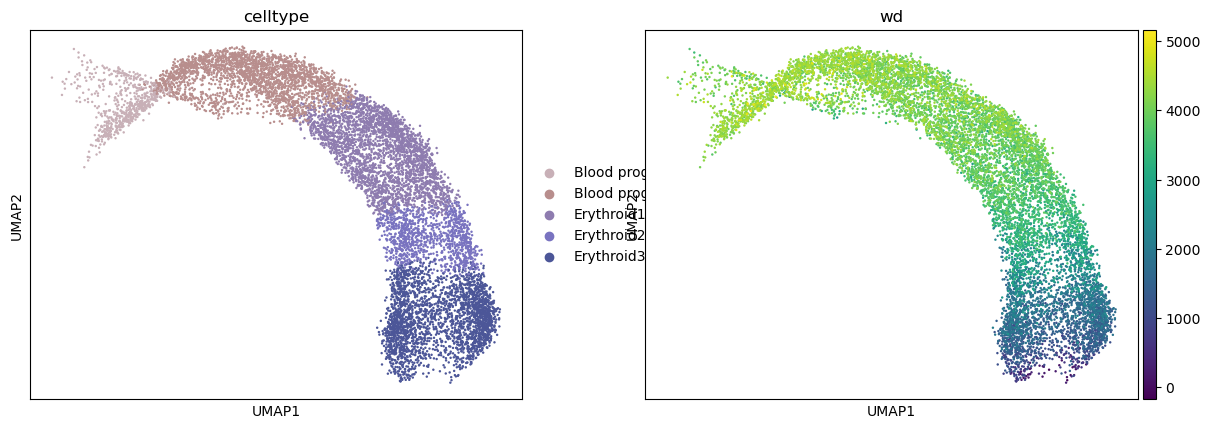

In [10]:
sc.pl.umap(adata, color=["celltype", "wd"])

In [11]:
import plotly.express as px
import pandas as pd

# Prepare data for plotting
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_umap"][:, 0],
    "UMAP2": adata.obsm["X_umap"][:, 1],
    "Value": adata.obs["wd"]  # Replace with your column name
})

# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="Value",
    color="Value",  # Color by the numerical column
    color_continuous_scale="Viridis",  # Color map
    title="3D Plot: UMAP + Numerical Value"
)

fig.update_traces(marker=dict(size=1))  # Adjust marker size
fig.show()


In [12]:
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_umap"][:, 0],
    "UMAP2": adata.obsm["X_umap"][:, 1],
    "Value": adata.obs["wd"],  # Replace with your numerical column name
    "Cluster": adata.obs["celltype"].astype(str)  # Replace with your cluster column name
})

# Compute cluster centroids
centroids = df.groupby("Cluster")[["UMAP1", "UMAP2", "Value"]].mean().reset_index()

# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="Value",
    color="Cluster",  # Cluster-based coloring
    color_discrete_sequence=px.colors.qualitative.Set3,  # Color map
    title="3D Plot with Cluster Labels"
)

# Add cluster labels at centroids
for _, row in centroids.iterrows():
    fig.add_scatter3d(
        x=[row["UMAP1"]],
        y=[row["UMAP2"]],
        z=[row["Value"]],
        mode="text",
        text=[f"{row['Cluster']}"],
        textfont=dict(size=10, color="black", family="Arial"),
        showlegend=False
    )

fig.update_traces(marker=dict(size=1))  # Adjust marker size
fig.show()


In [19]:
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_umap"][:, 0],
    "UMAP2": adata.obsm["X_umap"][:, 1],
    "Value": adata.obs["wd"],  # Replace with your numerical column name
    "Cluster": adata.obs["celltype"].astype(str)  # Replace with your cluster column name
})

# Compute cluster centroids
centroids = df.groupby("Cluster")[["UMAP1", "UMAP2", "Value"]].mean().reset_index()

# Create 3D scatter plot with gradient
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="Value",
    color="Value",  # Gradient for altitude
    color_continuous_scale="Viridis",  # Gradient colormap
    title="Mouse Erythroid Differentiation",
    labels={"Value": "ϕ (Potential)"}
)

# Add cluster labels at centroids
for _, row in centroids.iterrows():
    fig.add_scatter3d(
        x=[row["UMAP1"]],
        y=[row["UMAP2"]],
        z=[row["Value"]],
        mode="text",
        text=[f"{row['Cluster']}"],
        textfont=dict(size=13, color="black", family="Arial"),
        showlegend=False
    )

fig.update_traces(marker=dict(size=0.5))  # Adjust marker size
fig.show()


In [37]:
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    "UMAP1": adata.obsm["X_umap"][:, 0],
    "UMAP2": adata.obsm["X_umap"][:, 1],
    "Value": adata.obs["wd"],  # Replace with your numerical column name
    "Cluster": adata.obs["celltype"].astype(str)  # Replace with your cluster column name
})

# Compute cluster centroids
centroids = df.groupby("Cluster")[["UMAP1", "UMAP2", "Value"]].mean().reset_index()

# Create 3D scatter plot with gradient
fig = px.scatter_3d(
    df,
    x="UMAP1", y="UMAP2", z="Value",
    color="Value",  # Gradient for altitude
    color_continuous_scale="Viridis",  # Gradient colormap
    title="Mouse Erythroid Differentiation",
    labels={"Value": "ϕ (Potential)"}
)

# Add cluster labels at centroids
for _, row in centroids.iterrows():
    fig.add_scatter3d(
        x=[row["UMAP1"]],
        y=[row["UMAP2"]],
        z=[row["Value"]],
        mode="text",
        text=[f"{row['Cluster']}"],
        textfont=dict(size=13, color="black", family="Arial"),
        showlegend=False
    )

# Adjust layout to reduce whitespace
fig.update_layout(
    margin=dict(l=10, r=10, t=40, b=10),  # Reduce margins
    coloraxis_colorbar=dict(
        x=0.85,  # Move the color bar closer to the plot
        len=0.5,  # Reduce the size of the color bar
        title="ϕ (Potential)"
    ),
    scene=dict(
        aspectmode="manual",
        aspectratio=dict(x=1, y=1, z=0.7)  # Compact aspect ratio
    ),
    title=dict(
        x=0.5  # Center the title
    )
)

# Adjust marker size
fig.update_traces(marker=dict(size=1))  # Slightly increase marker size

# Show the improved plot
fig.show()


In [38]:
import plotly

html_content = plotly.io.to_html(fig, full_html=True)

# Save the HTML to a local file
output_file = "waddvelo_mouse_13_jan.html"
with open(output_file, 'w') as f:
    f.write(html_content)

print(f"HTML file saved to {output_file}")

HTML file saved to waddvelo_mouse_13_jan.html


In [15]:
fig.write_html("file.html")

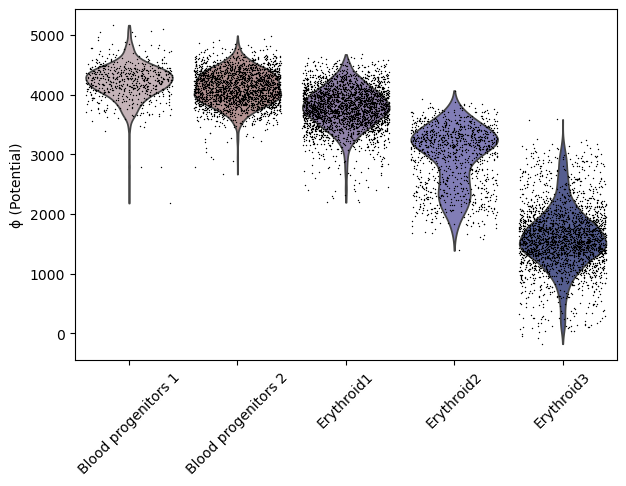

In [16]:
import scanpy as sc

# Assuming 'wd' is in adata.obs and 'celltype' is the category to group by
sc.pl.violin(adata, keys="wd", groupby="celltype", jitter=0.4, rotation=45, ylabel="ϕ (Potential)", save="mouse_violin.png")


In [21]:
adata.obs

sample stage sequencing.batch theiler             celltype  \
AAAGATCTCTCGAA      2  E7.5                1    TS11  Blood progenitors 2   
AATCTCACTGCTTT      2  E7.5                1    TS11  Blood progenitors 2   
AATGGCTGAAGATG      2  E7.5                1    TS11  Blood progenitors 2   
ACACATCTGTCAAC      2  E7.5                1    TS11  Blood progenitors 2   
ACGACAACTGGAGG      2  E7.5                1    TS11  Blood progenitors 2   
...               ...   ...              ...     ...                  ...   
TTTCACGACTGGTA     37  E8.5                3    TS12           Erythroid3   
TTTCAGTGCGAGTT     37  E8.5                3    TS12           Erythroid3   
TTTCGAACGGTGAG     37  E8.5                3    TS12           Erythroid3   
TTTCGAACTAACCG     37  E8.5                3    TS12           Erythroid3   
TTTCTACTTCTCTA     37  E8.5                3    TS12           Erythroid3   

                initial_size_unspliced  initial_size_spliced  initial_size  \
AAAGATCTCTCGAA                   702.0                9480.0        9480.0   
AATCTCACTGCTTT                   721.0                7055.0        7055.0   
AATGGCTGAAGATG                   702.0               12131.0       12131.0   
ACACATCTGTCAAC                   643.0                9148.0        9148.0   
ACGACAACTGGAGG                   302.0                4998.0        4998.0   
...                                ...                   ...           ...   
TTTCACGACTGGTA                   350.0                6949.0        6949.0   
TTTCAGTGCGAGTT                   631.0               15140.0       15140.0   
TTTCGAACGGTGAG                   905.0               19663.0       19663.0   
TTTCGAACTAACCG                   561.0               13046.0       13046.0   
TTTCTACTTCTCTA                   874.0               22383.0       22383.0   

                    n_counts  latent_time  sde_velocity_self_transition  \
AAAGATCTCTCGAA  11793.531250     0.101010                      0.216165   
AATCTCACTGCTTT  11664.036133     0.101010                      0.262824   
AATGGCTGAAGATG  11812.558594     0.101010                      0.155695   
ACACATCTGTCAAC  11837.477539     0.101010                      0.170974   
ACGACAACTGGAGG  11779.755859     0.121212                      0.161315   
...                      ...          ...                           ...   
TTTCACGACTGGTA  12015.311523     1.000000                      0.288719   
TTTCAGTGCGAGTT  11947.122070     1.000000                      0.405595   
TTTCGAACGGTGAG  11973.661133     1.000000                      0.327539   
TTTCGAACTAACCG  11973.789062     1.000000                      0.380458   
TTTCTACTTCTCTA  12014.865234     1.000000                      0.341725   

                sde_velocity_length  sde_velocity_confidence  \
AAAGATCTCTCGAA                15.94                 0.983063   
AATCTCACTGCTTT                15.86                 0.977672   
AATGGCTGAAGATG                15.98                 0.977254   
ACACATCTGTCAAC                16.07                 0.974111   
ACGACAACTGGAGG                15.05                 0.965459   
...                             ...                      ...   
TTTCACGACTGGTA                10.49                 0.973910   
TTTCAGTGCGAGTT                10.07                 0.979771   
TTTCGAACGGTGAG                10.53                 0.983713   
TTTCGAACTAACCG                10.13                 0.977350   
TTTCTACTTCTCTA                10.91                 0.982929   

                sde_velocity_confidence_transition           wd  
AAAGATCTCTCGAA                            0.236724  4288.141113  
AATCTCACTGCTTT                            0.158935  3968.459717  
AATGGCTGAAGATG                            0.293718  4404.306152  
ACACATCTGTCAAC                            0.342016  4587.229980  
ACGACAACTGGAGG                            0.230653  4261.985840  
...                                            ...          ...  
TTTCACGACTGGTA       

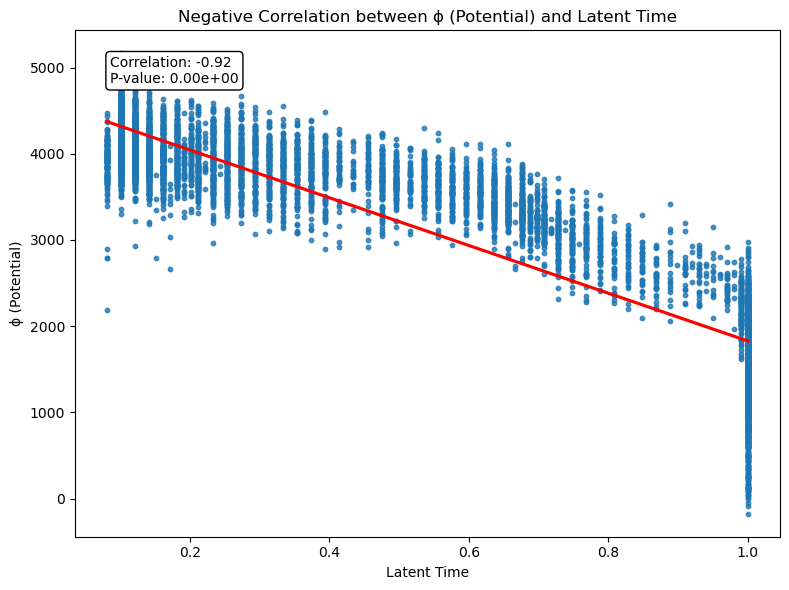

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Extract the specified columns from adata.obs
x = adata.obs["latent_time"]
y = adata.obs["wd"]

# Calculate the correlation coefficient and p-value
corr_coef, p_value = pearsonr(x, y)

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(x=x, y=y, scatter_kws={"s": 10}, line_kws={"color": "red"})

# Annotate with correlation coefficient and p-value
plt.annotate(f"Correlation: {corr_coef:.2f}\nP-value: {p_value:.2e}",
             xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top',
             fontsize=10, bbox=dict(boxstyle="round", fc="w"))

# Add labels and title
plt.xlabel("Latent Time")
plt.ylabel("ϕ (Potential)")
plt.title("Negative Correlation between ϕ (Potential) and Latent Time")

# Show the plot
plt.tight_layout()
plt.show()